# credit_card_balance Exploratory Data Analysis

## Introduction

Many people struggle to get loans because they don't have enough credit history, which can make them vulnerable to unfair lending practices. Home Credit Group addresses this issue by using alternative information, such as phone records and transaction data, to predict a person's ability to repay a loan. Improving these predictions helps reduce loan defaults, increases financial inclusion, and ensures more people receive fair, manageable loans.

In this analysis, the key outcome we want to predict is called the TARGET variable, found in the dataset file "application_train.csv." The TARGET variable indicates whether a loan was repaid (0) or defaulted on (1). Improving predictions on this variable allows Home Credit to better determine who will likely repay their loans, creating positive loan experiences and supporting long-term financial success.

## Goal

The credit_card_balance.csv dataset contains monthly balance snapshots of credit cards that applicants have with Home Credit. Each row represents a specific month's balance for a given credit card, capturing the applicant's credit usage over time. The dataset includes multiple rows for each applicant based on the number of credit cards they have and the available monthly data.

The goal when aggregating this dataset for the machine learning model is to create features that reflect the applicant's credit card usage and payment behavior. Aggregating features such as the total credit balance, average balance, and the frequency of payments made can help assess how the applicant manages credit. These aggregated features provide insights into the applicant’s financial habits and risk, which are useful for predicting their likelihood of repaying a new loan.

# Notebook Properation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.datasets import make_classification

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [2]:
from eda_utilities import *

In [3]:
train = pd.read_csv('data/application_train.csv', encoding = 'ISO-8859-1')
credit_card_balance = pd.read_csv('data/credit_card_balance.csv', encoding = 'ISO-8859-1')

### Check the number of rows, columns

In [4]:
credit_card_balance.shape

(3840312, 23)

The credit_card_balance dataset contains 1,551,870 rows and 23 columns, indicating that processing and analyzing the datset will likely require substantial computational resources.

### Any duplicates?

In [5]:
print(f"Number of duplicate rows: {len(credit_card_balance[credit_card_balance.duplicated(keep=False)])}")

Number of duplicate rows: 0


In [6]:
print(f"Number of duplicate rows (excluding SK_ID_CURR): {len(credit_card_balance.drop(columns=['SK_ID_CURR'])[credit_card_balance.drop(columns=['SK_ID_CURR']).duplicated(keep=False)])}")

Number of duplicate rows (excluding SK_ID_CURR): 0


In [7]:
print(f"Number of duplicate rows (excluding SK_ID_PREV): {len(credit_card_balance.drop(columns=['SK_ID_PREV'])[credit_card_balance.drop(columns=['SK_ID_PREV']).duplicated(keep=False)])}")

Number of duplicate rows (excluding SK_ID_PREV): 38


The credit_card_balance dataset shows 4 duplicate entries when excluding the unique identifier SK_ID_PREV indeed suggest that the same client (SK_ID_CURR) has multiple records in the dataset because they have applied for credit multiple times.

## Frame the Problem and look at the big picture

The data is highly imbalanced, with 91.9% in class 0 (no payment issues) and only 8.1% in class 1 (payment issues). This can cause models to favor the majority class, so techniques like resampling or class weighting are needed to handle it effectively.

### Check on the column datatype, null counts, distinct values, to get a better understanding of the data

In [8]:
column_summary(credit_card_balance)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,SK_ID_PREV,int64,0,3840312,104307,"{2377894: 96, 2581635: 96, 1130707: 96, 160295..."
1,SK_ID_CURR,int64,0,3840312,103558,"{186401: 192, 311118: 178, 120076: 140, 128827..."
2,MONTHS_BALANCE,int64,0,3840312,96,"{-4: 102115, -5: 100546, -3: 100355, -6: 98577..."
3,AMT_BALANCE,float64,0,3840312,1347904,"{0.0: 2156420, 67.5: 16049, 130.5: 3662, 270.0..."
4,AMT_CREDIT_LIMIT_ACTUAL,int64,0,3840312,181,"{0: 753823, 180000: 529292, 135000: 430142, 45..."
5,AMT_DRAWINGS_ATM_CURRENT,float64,749816,3090496,2267,"{0.0: 2665718, 4500.0: 35851, 9000.0: 27726, 4..."
6,AMT_DRAWINGS_CURRENT,float64,0,3840312,187005,"{0.0: 3223443, 4500.0: 30257, 9000.0: 22968, 2..."
7,AMT_DRAWINGS_OTHER_CURRENT,float64,749816,3090496,1832,"{0.0: 3078163, 3343.5: 782, 6682.5: 460, 4455...."
8,AMT_DRAWINGS_POS_CURRENT,float64,749816,3090496,168748,"{0.0: 2825595, 450.0: 1287, 900.0: 976, 2250.0..."
9,AMT_INST_MIN_REGULARITY,float64,305236,3535076,312266,"{0.0: 1928864, 9000.0: 225429, 6750.0: 147469,..."


In [9]:
credit_card_balance_summary = column_summary(credit_card_balance)
credit_card_balance_summary.to_csv('data_summaries/credit_summary.csv')

Saving the summary as a CSV file allows for a clearer and more structured view of the data, making it easier to analyze column details, missing values, and distinct values outside of the code environment.

### Check the distribution of what data type is being used in the dataset

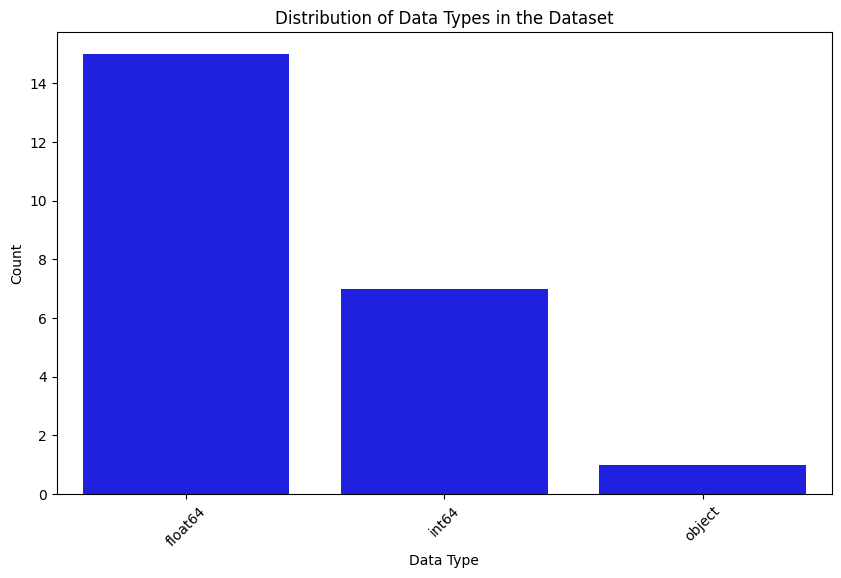

In [10]:
data_types = credit_card_balance.dtypes.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=data_types.index, y=data_types.values, color='blue')
plt.title('Distribution of Data Types in the Dataset')
plt.xlabel('Data Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

float64 is the most common type, with more than 17 features. int64 and object types have fewer occurrences, with int64 being slightly more prevalent than object.

These differences suggest the datasets differ significantly in complexity and the variety of feature types available. The first dataset is richer in numerical features (especially floats), while the second is evenly split among numerical (integers and floats) and categorical (object) types.

# Aggregating and Creating Features

The POS_CASH_balance dataset contains detailed monthly records of previous point-of-sale (POS) and cash loans for each customer. Due to its large size (~10 million rows), it was processed independently from other datasets to reduce memory usage and processing time.

Since this dataset includes many monthly records per loan, we aggregated the data to create customer-level features that summarize past loan behavior efficiently. These features help the machine learning model understand how applicants managed previous loans, which can indicate their ability to repay future loans.

In [11]:
# Convert NAME_CONTRACT_STATUS to dummy variables
status_dummies = pd.get_dummies(credit_card_balance['NAME_CONTRACT_STATUS'], prefix='STATUS')
credit_card_balance = pd.concat([credit_card_balance, status_dummies], axis=1)

# Identify status columns after creating dummies
status_cols = [col for col in credit_card_balance.columns if col.startswith('STATUS_')]

# Aggregation dictionary for SK_ID_PREV
agg_dict_prev = {
    'SK_ID_CURR': 'first',
    'MONTHS_BALANCE': ['count', 'max'],
    'AMT_BALANCE': ['mean', 'max', 'sum'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['sum', 'mean', 'max'],
    'AMT_DRAWINGS_CURRENT': ['sum', 'mean', 'max'],
    'AMT_DRAWINGS_OTHER_CURRENT': ['sum', 'mean'],
    'AMT_DRAWINGS_POS_CURRENT': ['sum', 'mean'],
    'AMT_INST_MIN_REGULARITY': ['mean', 'min'],
    'AMT_PAYMENT_CURRENT': ['sum', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['sum', 'mean'],
    'AMT_RECEIVABLE_PRINCIPAL': ['mean', 'sum'],
    'AMT_RECIVABLE': ['mean', 'sum'],
    'AMT_TOTAL_RECEIVABLE': ['mean', 'sum'],
    'CNT_DRAWINGS_ATM_CURRENT': ['sum', 'mean'],
    'CNT_DRAWINGS_CURRENT': ['sum', 'mean'],
    'CNT_DRAWINGS_OTHER_CURRENT': ['sum', 'mean'],
    'CNT_DRAWINGS_POS_CURRENT': ['sum', 'mean'],
    'CNT_INSTALMENT_MATURE_CUM': ['mean', 'max'],
    'SK_DPD': ['max', 'mean', 'sum'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
}

# Add status columns to the aggregation
for col in status_cols:
    agg_dict_prev[col] = ['sum', 'mean']

# Aggregate by SK_ID_PREV
credit_prev_agg = credit_card_balance.groupby('SK_ID_PREV').agg(agg_dict_prev)

# Flatten multi-level column names
credit_prev_agg.columns = [f"{col[0]}_{col[1].upper()}" if col[1] != '' else col[0]
                           for col in credit_prev_agg.columns]
credit_prev_agg.reset_index(inplace=True)
credit_prev_agg.rename(columns={'SK_ID_CURR_FIRST': 'SK_ID_CURR'}, inplace=True)

# Identify status-related columns from the previous aggregation
status_sum_cols = [col for col in credit_prev_agg.columns if col.endswith('_SUM') and col.startswith('STATUS_')]
status_mean_cols = [col for col in credit_prev_agg.columns if col.endswith('_MEAN') and col.startswith('STATUS_')]

# Aggregation dictionary for SK_ID_CURR
agg_dict_curr = {
    'SK_ID_PREV': ['count'],
    'MONTHS_BALANCE_COUNT': ['sum', 'mean', 'max'],
    'MONTHS_BALANCE_MAX': ['max'],
    'AMT_BALANCE_MEAN': ['mean', 'max'],
    'AMT_BALANCE_MAX': ['max'],
    'AMT_BALANCE_SUM': ['sum'],
    'AMT_CREDIT_LIMIT_ACTUAL_MEAN': ['mean'],
    'AMT_CREDIT_LIMIT_ACTUAL_MAX': ['max'],
    'AMT_DRAWINGS_ATM_CURRENT_SUM': ['sum'],
    'AMT_DRAWINGS_ATM_CURRENT_MEAN': ['mean'],
    'AMT_DRAWINGS_ATM_CURRENT_MAX': ['max'],
    'AMT_DRAWINGS_CURRENT_SUM': ['sum'],
    'AMT_DRAWINGS_CURRENT_MEAN': ['mean'],
    'AMT_DRAWINGS_CURRENT_MAX': ['max'],
    'AMT_DRAWINGS_OTHER_CURRENT_SUM': ['sum'],
    'AMT_DRAWINGS_OTHER_CURRENT_MEAN': ['mean'],
    'AMT_DRAWINGS_POS_CURRENT_SUM': ['sum'],
    'AMT_DRAWINGS_POS_CURRENT_MEAN': ['mean'],
    'AMT_INST_MIN_REGULARITY_MEAN': ['mean'],
    'AMT_INST_MIN_REGULARITY_MIN': ['min'],
    'AMT_PAYMENT_CURRENT_SUM': ['sum'],
    'AMT_PAYMENT_CURRENT_MEAN': ['mean'],
    'AMT_PAYMENT_TOTAL_CURRENT_SUM': ['sum'],
    'AMT_PAYMENT_TOTAL_CURRENT_MEAN': ['mean'],
    'AMT_RECEIVABLE_PRINCIPAL_MEAN': ['mean'],
    'AMT_RECEIVABLE_PRINCIPAL_SUM': ['sum'],
    'AMT_RECIVABLE_MEAN': ['mean'],
    'AMT_RECIVABLE_SUM': ['sum'],
    'AMT_TOTAL_RECEIVABLE_MEAN': ['mean'],
    'AMT_TOTAL_RECEIVABLE_SUM': ['sum'],
    'CNT_DRAWINGS_ATM_CURRENT_SUM': ['sum'],
    'CNT_DRAWINGS_ATM_CURRENT_MEAN': ['mean'],
    'CNT_DRAWINGS_CURRENT_SUM': ['sum'],
    'CNT_DRAWINGS_CURRENT_MEAN': ['mean'],
    'CNT_DRAWINGS_OTHER_CURRENT_SUM': ['sum'],
    'CNT_DRAWINGS_OTHER_CURRENT_MEAN': ['mean'],
    'CNT_DRAWINGS_POS_CURRENT_SUM': ['sum'],
    'CNT_DRAWINGS_POS_CURRENT_MEAN': ['mean'],
    'CNT_INSTALMENT_MATURE_CUM_MEAN': ['mean'],
    'CNT_INSTALMENT_MATURE_CUM_MAX': ['max'],
    'SK_DPD_MAX': ['max', 'mean'],
    'SK_DPD_MEAN': ['mean'],
    'SK_DPD_SUM': ['sum'],
    'SK_DPD_DEF_MAX': ['max', 'mean'],
    'SK_DPD_DEF_MEAN': ['mean'],
    'SK_DPD_DEF_SUM': ['sum'],
}

# Add status columns
for col in status_sum_cols:
    agg_dict_curr[col] = ['sum']
for col in status_mean_cols:
    agg_dict_curr[col] = ['mean']

# Aggregate by SK_ID_CURR
credit_final_agg = credit_prev_agg.groupby('SK_ID_CURR').agg(agg_dict_curr)

# Flatten and prefix column names
credit_final_agg.columns = ["CREDIT_" + "_".join(col).upper() for col in credit_final_agg.columns]
credit_final_agg.reset_index(inplace=True)

# Assuming train is a DataFrame with SK_ID_CURR and TARGET
agg_credit = credit_final_agg.merge(train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

agg_credit.head()

,SK_ID_CURR,CREDIT_SK_ID_PREV_COUNT,CREDIT_MONTHS_BALANCE_COUNT_SUM,CREDIT_MONTHS_BALANCE_COUNT_MEAN,CREDIT_MONTHS_BALANCE_COUNT_MAX,CREDIT_MONTHS_BALANCE_MAX_MAX,CREDIT_AMT_BALANCE_MEAN_MEAN,CREDIT_AMT_BALANCE_MEAN_MAX,CREDIT_AMT_BALANCE_MAX_MAX,CREDIT_AMT_BALANCE_SUM_SUM,...,CREDIT_STATUS_SENT PROPOSAL_SUM_SUM,CREDIT_STATUS_SIGNED_SUM_SUM,CREDIT_STATUS_ACTIVE_MEAN_MEAN,CREDIT_STATUS_APPROVED_MEAN_MEAN,CREDIT_STATUS_COMPLETED_MEAN_MEAN,CREDIT_STATUS_DEMAND_MEAN_MEAN,CREDIT_STATUS_REFUSED_MEAN_MEAN,CREDIT_STATUS_SENT PROPOSAL_MEAN_MEAN,CREDIT_STATUS_SIGNED_MEAN_MEAN,TARGET
0,100006,1,6,6.0,6,-1,0.000000,0.000000,0.00,0.000,...,0,0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,100011,1,74,74.0,74,-2,54482.111149,54482.111149,189000.00,4031676.225,...,0,0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,100013,1,96,96.0,96,-1,18159.919219,18159.919219,161420.22,1743352.245,...,0,0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,NaN
3,100021,1,17,17.0,17,-2,0.000000,0.000000,0.00,0.000,...,0,0,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0,0.0
4,100023,1,8,8.0,8,-4,0.000000,0.000000,0.00,0.000,...,0,0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [12]:
agg_credit.shape

(103558, 67)

After aggregation, the agg_pos dataset contains 101,804 rows and 67 features, summarizing previous loan applications at the client level.

# EDA

Since all our features are numerical after aggregation, we focused on showing how each one is distributed and how it relates to the TARGET variable.

* If a feature has fewer than 20 unique values, we used bar plots and proportion plots to make the patterns easy to see.
* If a feature has more than 20 unique values, we used histograms and boxplots to show the distribution and spot any outliers.

In [13]:
agg_credit = agg_credit[agg_credit['TARGET'].notnull()]

### Client and Contract Identifiers

In [14]:
agg_credit['SK_ID_CURR'].nunique()

86905

There are 85,214 unique clients in the dataset, each identified by SK_ID_CURR, representing individual client records for further analysis.

### Count and Activity Features

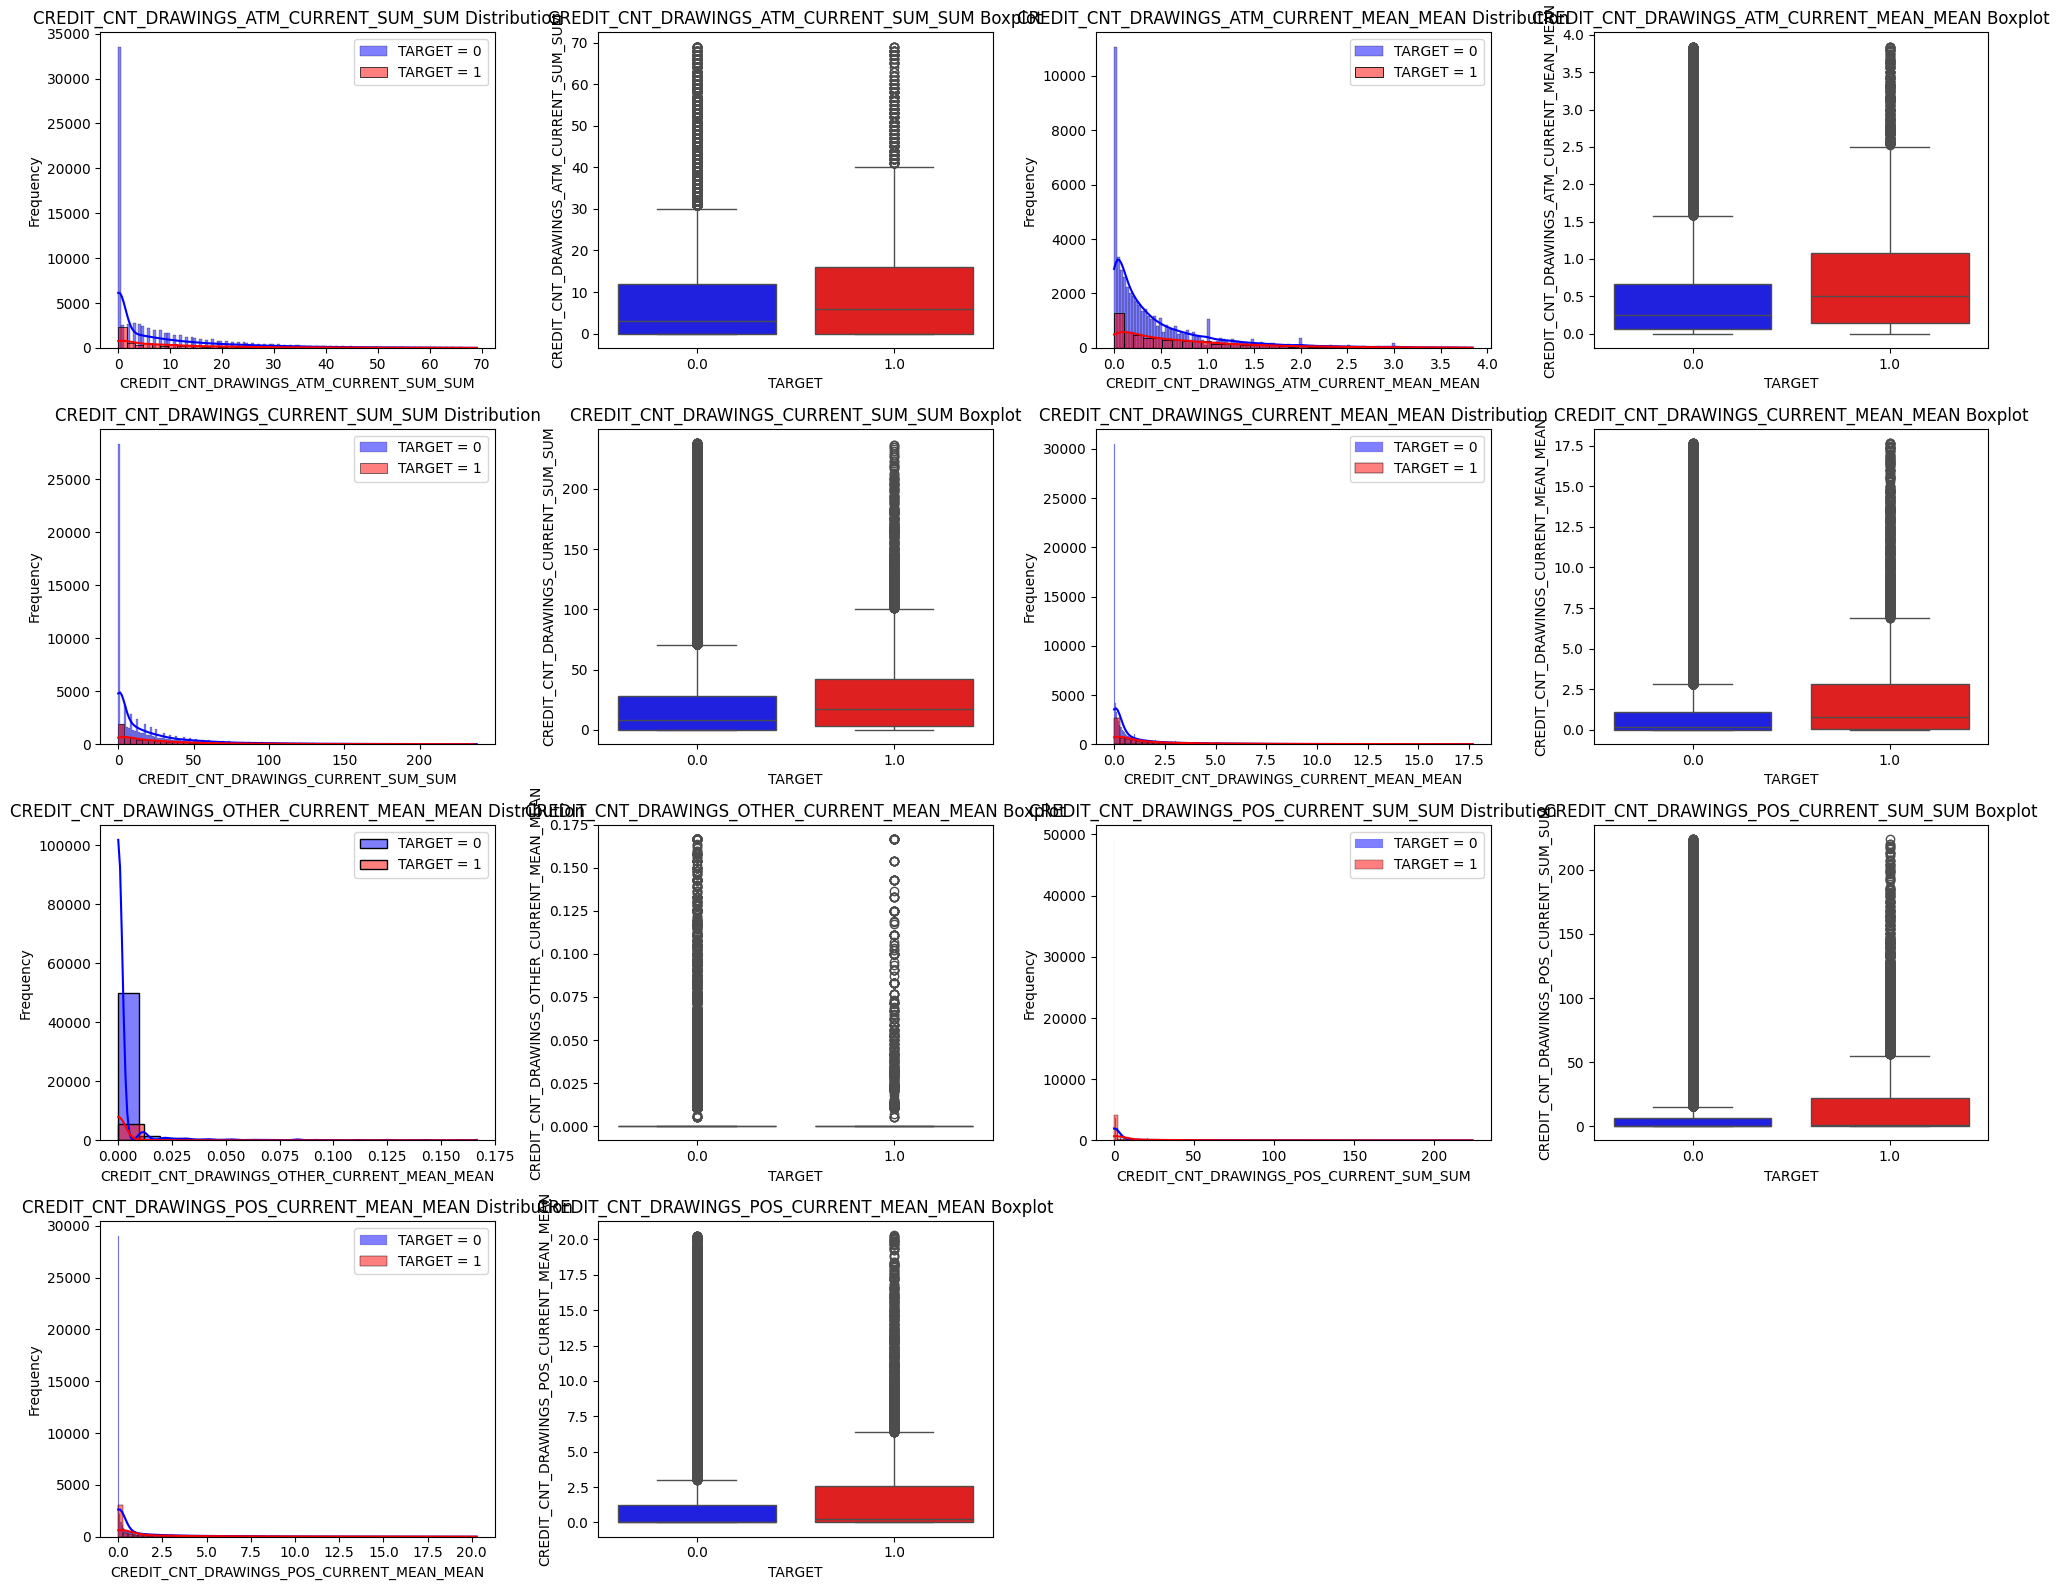

In [15]:
plot_multiple_numeric_dists(
    agg_credit,
    features = [
         'CREDIT_CNT_DRAWINGS_ATM_CURRENT_SUM_SUM',
         'CREDIT_CNT_DRAWINGS_ATM_CURRENT_MEAN_MEAN',
         'CREDIT_CNT_DRAWINGS_CURRENT_SUM_SUM',
         'CREDIT_CNT_DRAWINGS_CURRENT_MEAN_MEAN',
         'CREDIT_CNT_DRAWINGS_OTHER_CURRENT_MEAN_MEAN',
         'CREDIT_CNT_DRAWINGS_POS_CURRENT_SUM_SUM',
         'CREDIT_CNT_DRAWINGS_POS_CURRENT_MEAN_MEAN'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
         'CREDIT_CNT_DRAWINGS_ATM_CURRENT_SUM_SUM',
         'CREDIT_CNT_DRAWINGS_ATM_CURRENT_MEAN_MEAN',
         'CREDIT_CNT_DRAWINGS_CURRENT_SUM_SUM',
         'CREDIT_CNT_DRAWINGS_CURRENT_MEAN_MEAN',
         'CREDIT_CNT_DRAWINGS_OTHER_CURRENT_MEAN_MEAN',
         'CREDIT_CNT_DRAWINGS_POS_CURRENT_SUM_SUM',
         'CREDIT_CNT_DRAWINGS_POS_CURRENT_MEAN_MEAN'
    ],
    percentile =0.99
)

1. CREDIT_CNT_DRAWINGS_ATM_CURRENT_SUM_SUM: The distribution is right-skewed with most values near 0, and the boxplot shows a notable difference in the spread between TARGET=0 (non-default) and TARGET=1 (defaults). Clients with higher values in CREDIT_CNT_DRAWINGS_ATM_CURRENT_SUM_SUM seem more likely to default. The feature shows some promise but may require handling for the skewness and outliers.
2. CREDIT_CNT_DRAWINGS_ATM_CURRENT_MEAN_MEAN: This feature has a similar distribution, with a concentration around 0 and a few higher values. The boxplot reveals a wider spread for TARGET=1 compared to TARGET=0, indicating that clients with larger values in this feature are more likely to default. Outlier handling will be necessary to improve its utility for the model.
3. CREDIT_CNT_DRAWINGS_OTHER_CURRENT_MEAN_MEAN: The distribution shows most values concentrated near 0 with a long tail on the higher end, and the boxplot shows a wider spread for TARGET=1. While the feature does show some variability, its concentration near 0 and extreme values suggest it may need preprocessing for better model performance.
4. CREDIT_CNT_DRAWINGS_POS_CURRENT_MEAN_MEAN: The distribution is right-skewed with values primarily near 0. The boxplot shows a wider spread for TARGET=1 compared to TARGET=0, implying that clients with higher values in this feature are more likely to default. This feature may be useful but should be processed for its skewness and outliers.
5. CREDIT_CNT_DRAWINGS_POS_CURRENT_SUM_SUM: The distribution for this feature has a peak near 0, and the boxplot shows that TARGET=1 has a wider spread than TARGET=0, which could suggest that clients with higher values in CREDIT_CNT_DRAWINGS_POS_CURRENT_SUM_SUM may have a higher probability of defaulting. This feature has potential but would benefit from handling the outliers.
6. CREDIT_CNT_DRAWINGS_POS_CURRENT_SUM_MEAN: The distribution shows a concentration of values around 0, with some higher values, and the boxplot shows outliers for TARGET=1. The difference in spread between TARGET=0 and TARGET=1 suggests that this feature could help in distinguishing defaults. However, outliers need to be handled for effective use.
7. CREDIT_CNT_DRAWINGS_POS_CURRENT_MEAN_MEAN: Similar to other features, this feature is concentrated around 0, with higher values showing a wider spread for TARGET=1. The potential for distinguishing defaulted clients is evident, but proper outlier treatment and possibly transformation of the skewed data are needed to improve its usefulness.

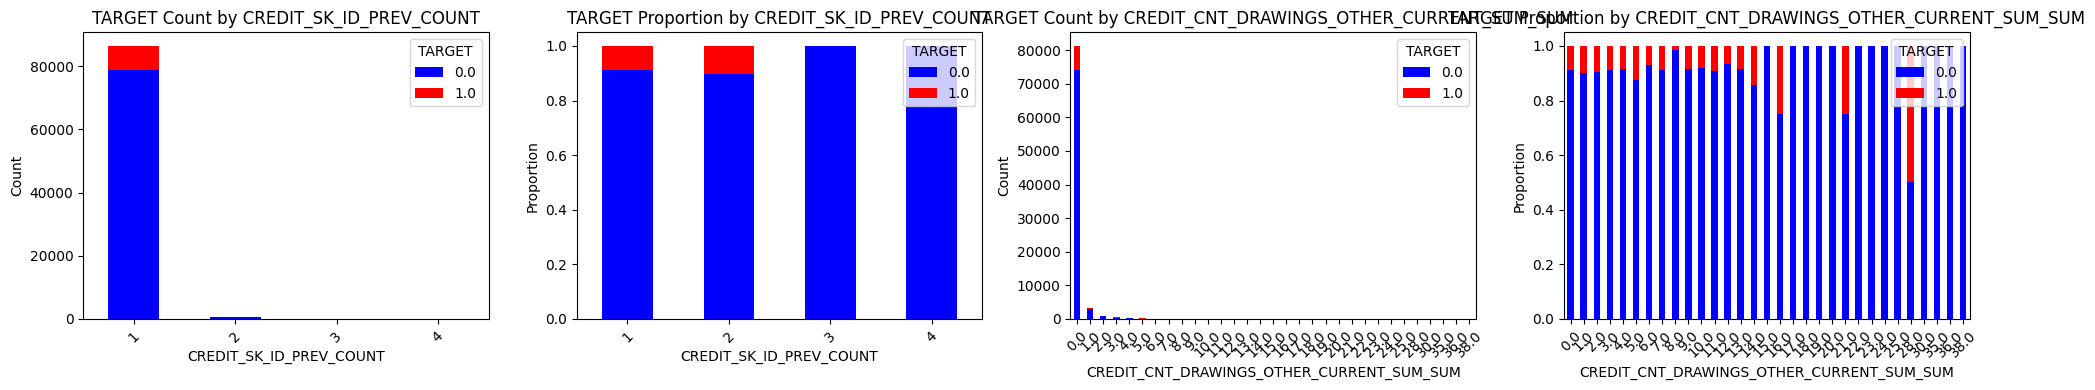

In [16]:
plot_multiple_categorical_dists(
    agg_credit,
    features = [
        'CREDIT_SK_ID_PREV_COUNT',
        'CREDIT_CNT_DRAWINGS_OTHER_CURRENT_SUM_SUM'
        ],
    target = 'TARGET'
    )

1. CREDIT_SK_ID_PREV_COUNT: The TARGET Count plot shows that the majority of values for this feature are concentrated around 1, with very few clients having values greater than 1. The TARGET Proportion plot shows a similar distribution for both TARGET=0 and TARGET=1 across the different values. This suggests that this feature doesn't add significant predictive value as the distribution of defaults is fairly consistent across all values.
2. CREDIT_CNT_DRAWINGS_OTHER_CURRENT_SUM_SUM: The TARGET Count plot shows a concentration around 0, with very few instances having higher values. The TARGET Proportion plot reveals a similar pattern, with both TARGET=0 and TARGET=1 maintaining a consistent proportion across values. This indicates that the feature lacks variability and may not provide useful information for distinguishing between defaulted and non-defaulted clients.

#### Temporal Features

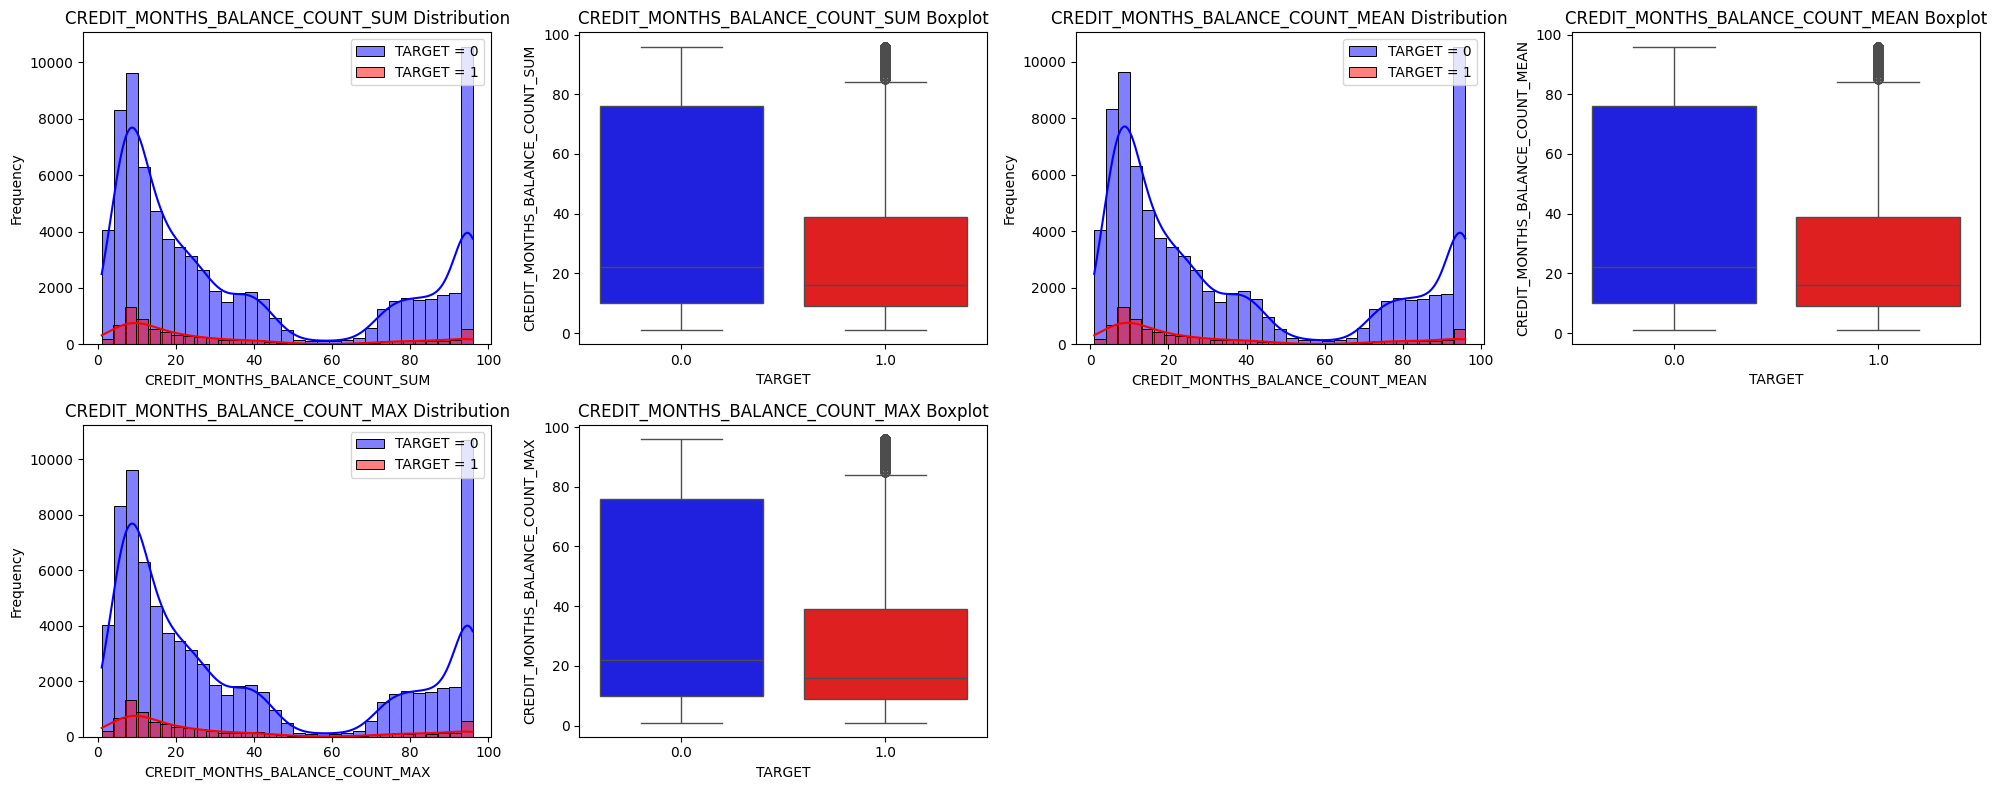

In [17]:
plot_multiple_numeric_dists(
    agg_credit,
    features = [
         'CREDIT_MONTHS_BALANCE_COUNT_SUM',
         'CREDIT_MONTHS_BALANCE_COUNT_MEAN',
         'CREDIT_MONTHS_BALANCE_COUNT_MAX',
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
         'CREDIT_MONTHS_BALANCE_COUNT_SUM',
         'CREDIT_MONTHS_BALANCE_COUNT_MEAN',
         'CREDIT_MONTHS_BALANCE_COUNT_MAX',
    ],
    percentile =0.99
)

1. CREDIT_MONTHS_BALANCE_COUNT_SUM: The distribution is right-skewed, with most values concentrated around 0, and the boxplot shows a noticeable difference between TARGET=0 (non-default) and TARGET=1 (defaults). The clients with higher CREDIT_MONTHS_BALANCE_COUNT_SUM values are more likely to default, making this feature potentially useful for the model, although it should be processed for skewness and outliers.
2. CREDIT_MONTHS_BALANCE_COUNT_MAX: Similar to the previous feature, the distribution is right-skewed, with a concentration of values near 0. The boxplot indicates that clients with higher values in CREDIT_MONTHS_BALANCE_COUNT_MAX tend to default more often. This feature could be valuable for identifying default risks, but it requires transformation and outlier handling to be more effective in the model.
3. CREDIT_MONTHS_BALANCE_COUNT_MEAN: The distribution for CREDIT_MONTHS_BALANCE_COUNT_MEAN shows a heavy concentration around 0, with some larger values that differentiate TARGET=1 from TARGET=0 in the boxplot. Clients with higher values in this feature are more likely to default. While useful, the feature should undergo appropriate preprocessing to account for its skewness and outliers.

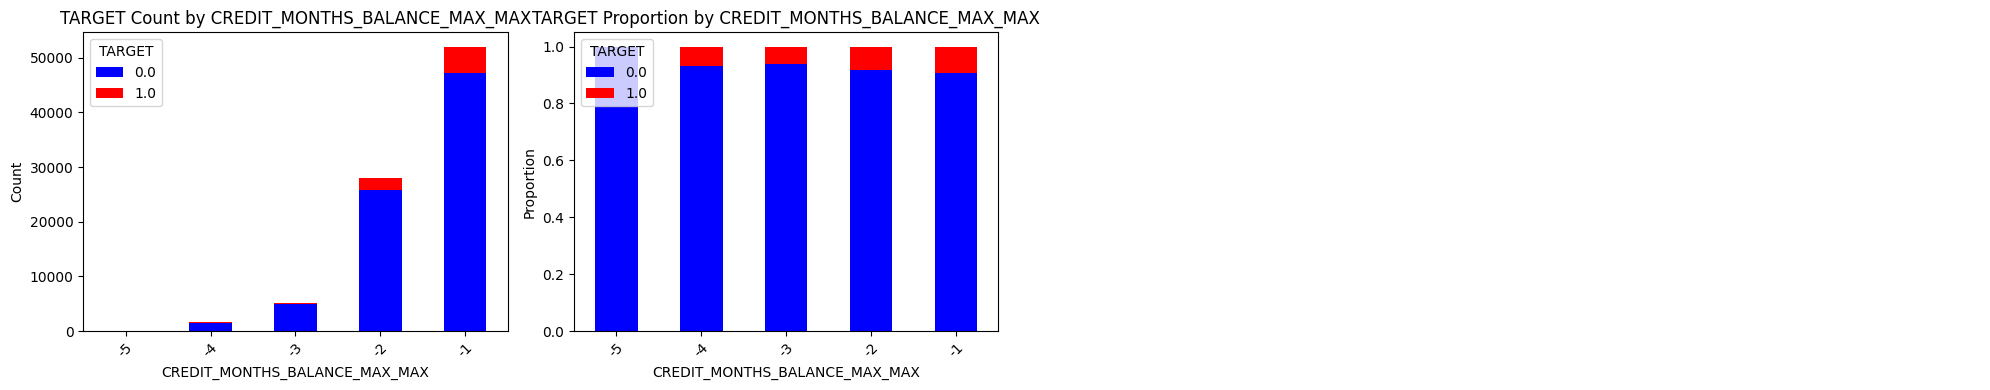

In [18]:
plot_multiple_categorical_dists(
    agg_credit,
    features = [
        'CREDIT_MONTHS_BALANCE_MAX_MAX'
        ],
    target = 'TARGET'
    )

The feature CREDIT_MONTHS_BALANCE_MAX_MAX mostly shows values near 0, with a few higher values (around 2-4). Both target classes (TARGET = 0 and TARGET = 1) have similar distributions, suggesting that this feature does not strongly differentiate between the two groups.

#### Balance and Credit Limit Features

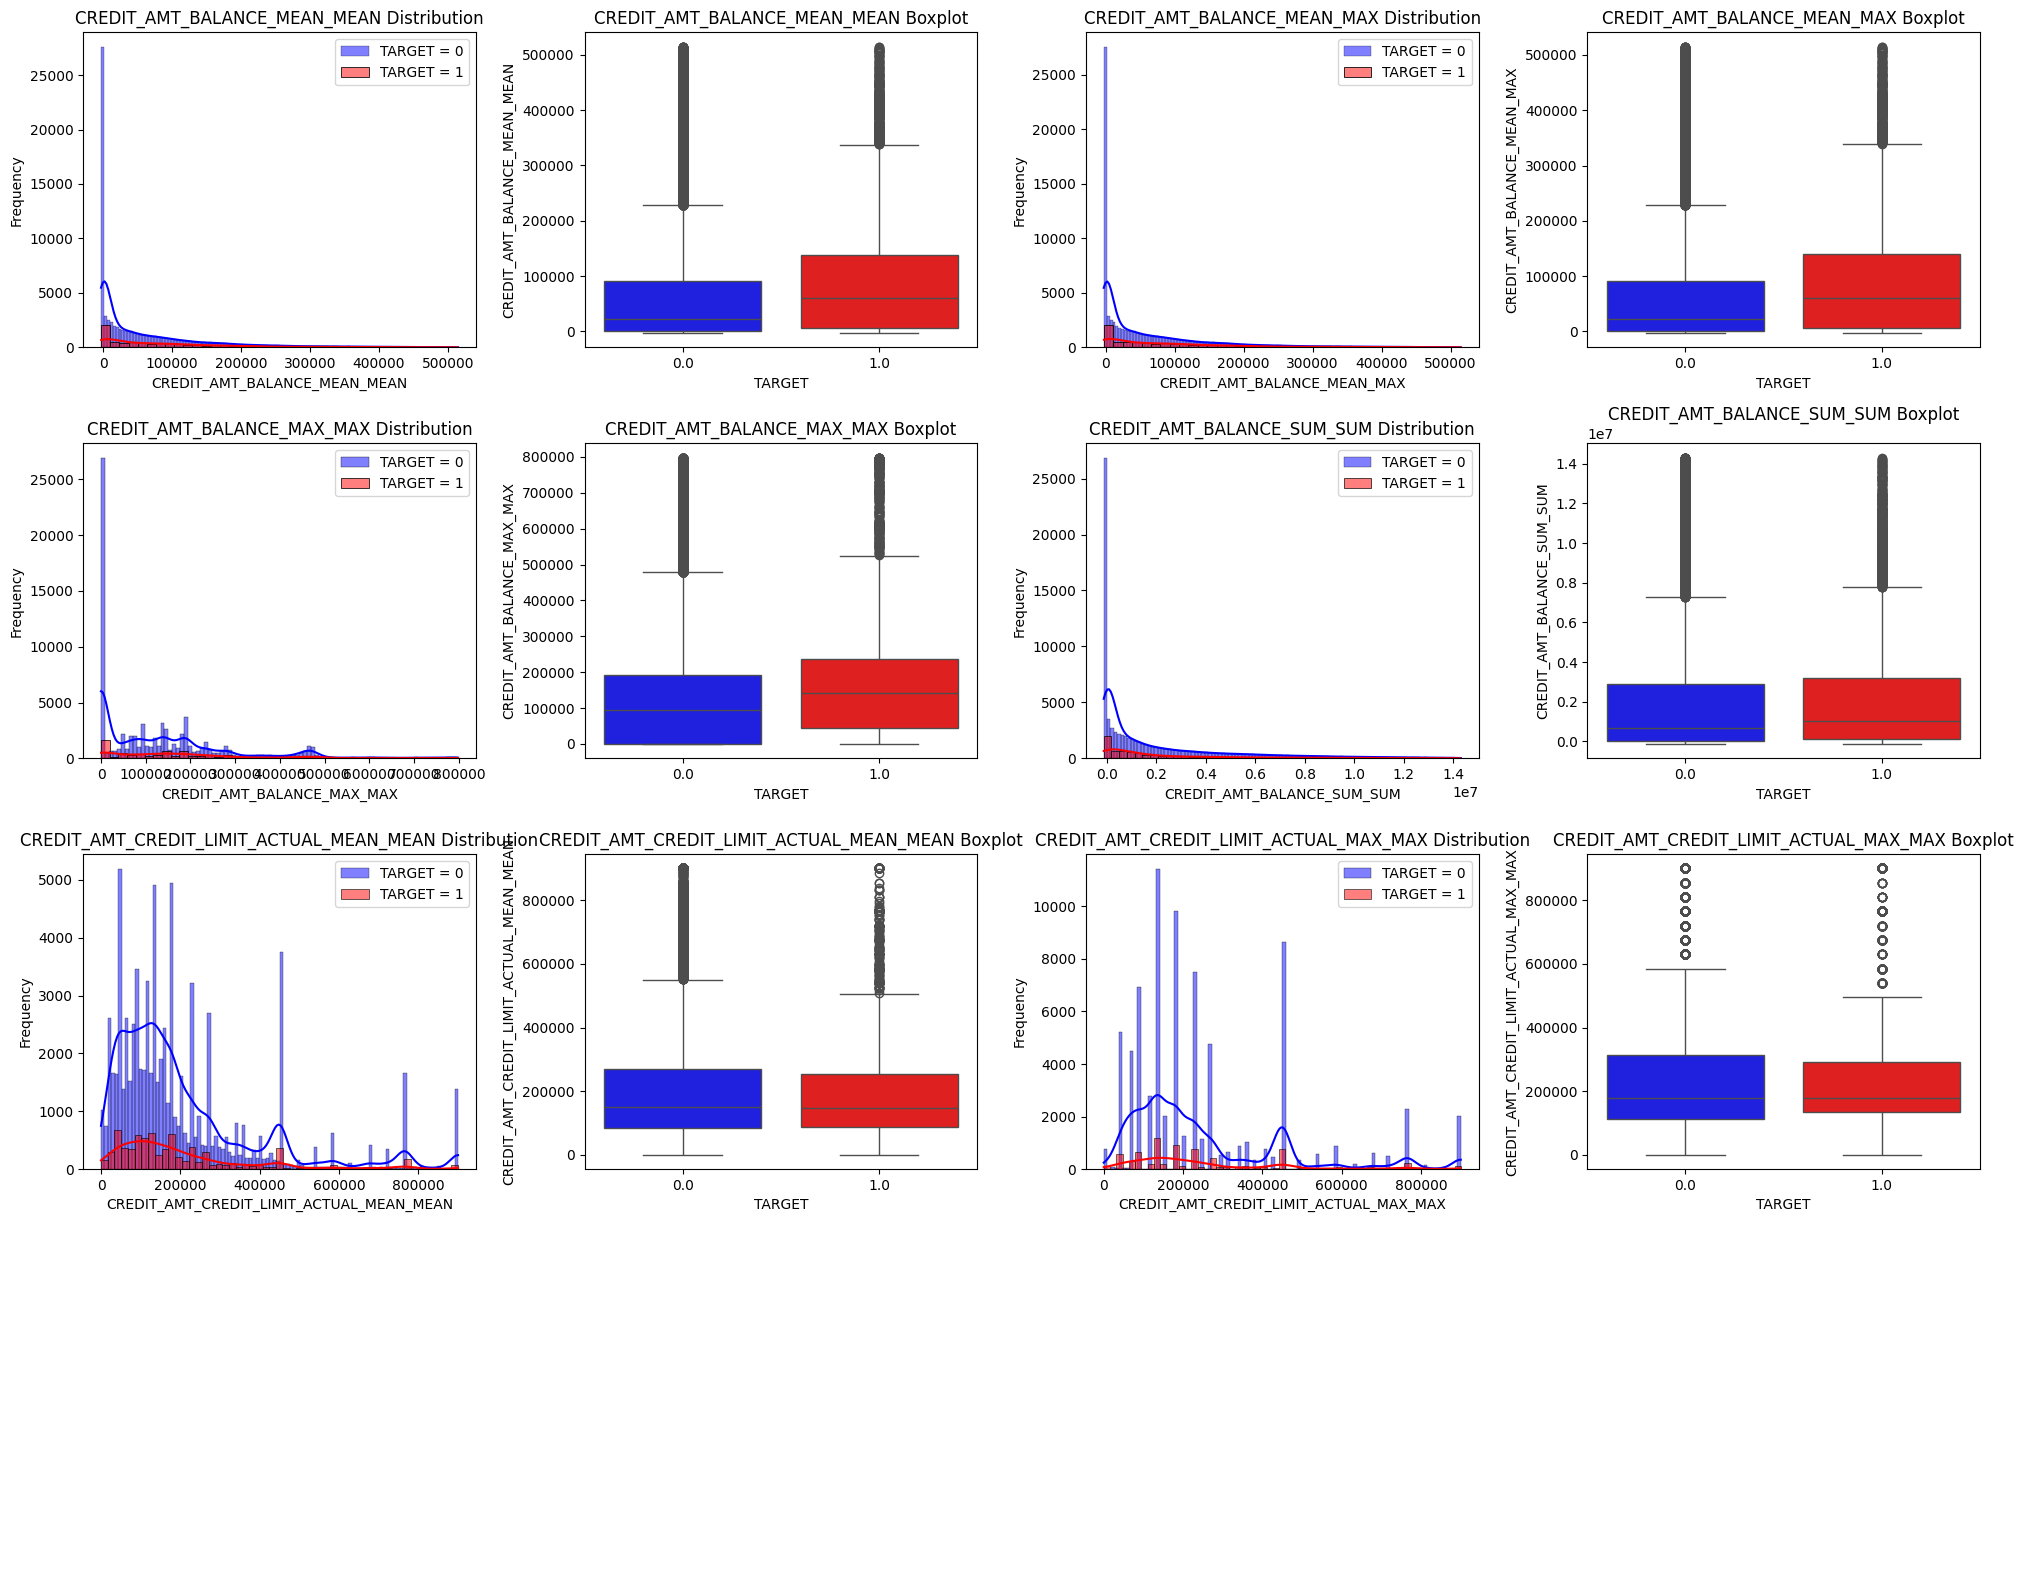

In [19]:
plot_multiple_numeric_dists(
    agg_credit,
    features = [
         'CREDIT_AMT_BALANCE_MEAN_MEAN',
         'CREDIT_AMT_BALANCE_MEAN_MAX',
         'CREDIT_AMT_BALANCE_MAX_MAX',
         'CREDIT_AMT_BALANCE_SUM_SUM',
         'CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MEAN_MEAN',
         'CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MAX_MAX'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
         'CREDIT_AMT_BALANCE_MEAN_MEAN',
         'CREDIT_AMT_BALANCE_MEAN_MAX',
         'CREDIT_AMT_BALANCE_MAX_MAX',
         'CREDIT_AMT_BALANCE_SUM_SUM',
         'CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MEAN_MEAN',
         'CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MAX_MAX'
    ],
    percentile =0.99
)

1. CREDIT_AMT_BALANCE_MEAN: The distribution of CREDIT_AMT_BALANCE_MEAN is highly right-skewed, with the majority of values clustered around 0. The boxplot shows a distinct difference between TARGET=0 (non-default) and TARGET=1 (defaults), with higher values of the feature being associated with defaults. This feature appears to capture important information regarding defaulted loans but requires transformation to handle the skewness and outliers.
2. CREDIT_AMT_BALANCE_MAX_MAX: Similar to the CREDIT_AMT_BALANCE_MEAN, the distribution of CREDIT_AMT_BALANCE_MAX_MAX is right-skewed, with a significant concentration around 0. The boxplot also shows that clients with higher values in CREDIT_AMT_BALANCE_MAX_MAX tend to default (TARGET=1). This feature might help in predicting defaults but should undergo preprocessing for skewness and handling of outliers.
3. CREDIT_AMT_BALANCE_SUM_SUM: The distribution of CREDIT_AMT_BALANCE_SUM_SUM is again highly right-skewed, and the boxplot shows that the median value for TARGET=0 (non-default) is lower than for TARGET=1 (defaults). Clients with higher sums of CREDIT_AMT_BALANCE_SUM_SUM are more likely to default, suggesting that this feature might be valuable for the model with proper handling of its skewness.
4. CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MEAN: The distribution of CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MEAN is somewhat normal but still has a slight right skew. The boxplot indicates that TARGET=1 (defaults) clients tend to have slightly higher values of this feature compared to TARGET=0 (non-default) clients. This suggests that this feature could potentially help distinguish between default and non-default clients.
5. CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MAX_MAX: CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MAX_MAX also exhibits a right-skewed distribution, with higher values of the feature being more likely to appear in defaulted clients (TARGET=1). The boxplot shows clear differentiation between TARGET=0 and TARGET=1, indicating that the feature could help with the prediction of defaults, though it requires proper preprocessing to address its skewness and outliers.
6. CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MAX_MEAN: Similar to the previous features, the distribution for CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MAX_MEAN is skewed to the right, with the majority of values concentrated at lower levels. The boxplot also reveals that clients with higher values of CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MAX_MEAN are more likely to default (TARGET=1). This feature has predictive value but should undergo preprocessing for skewness and outlier removal to improve its effectiveness in a machine learning model.

#### Drawing (Withdrawal) Features

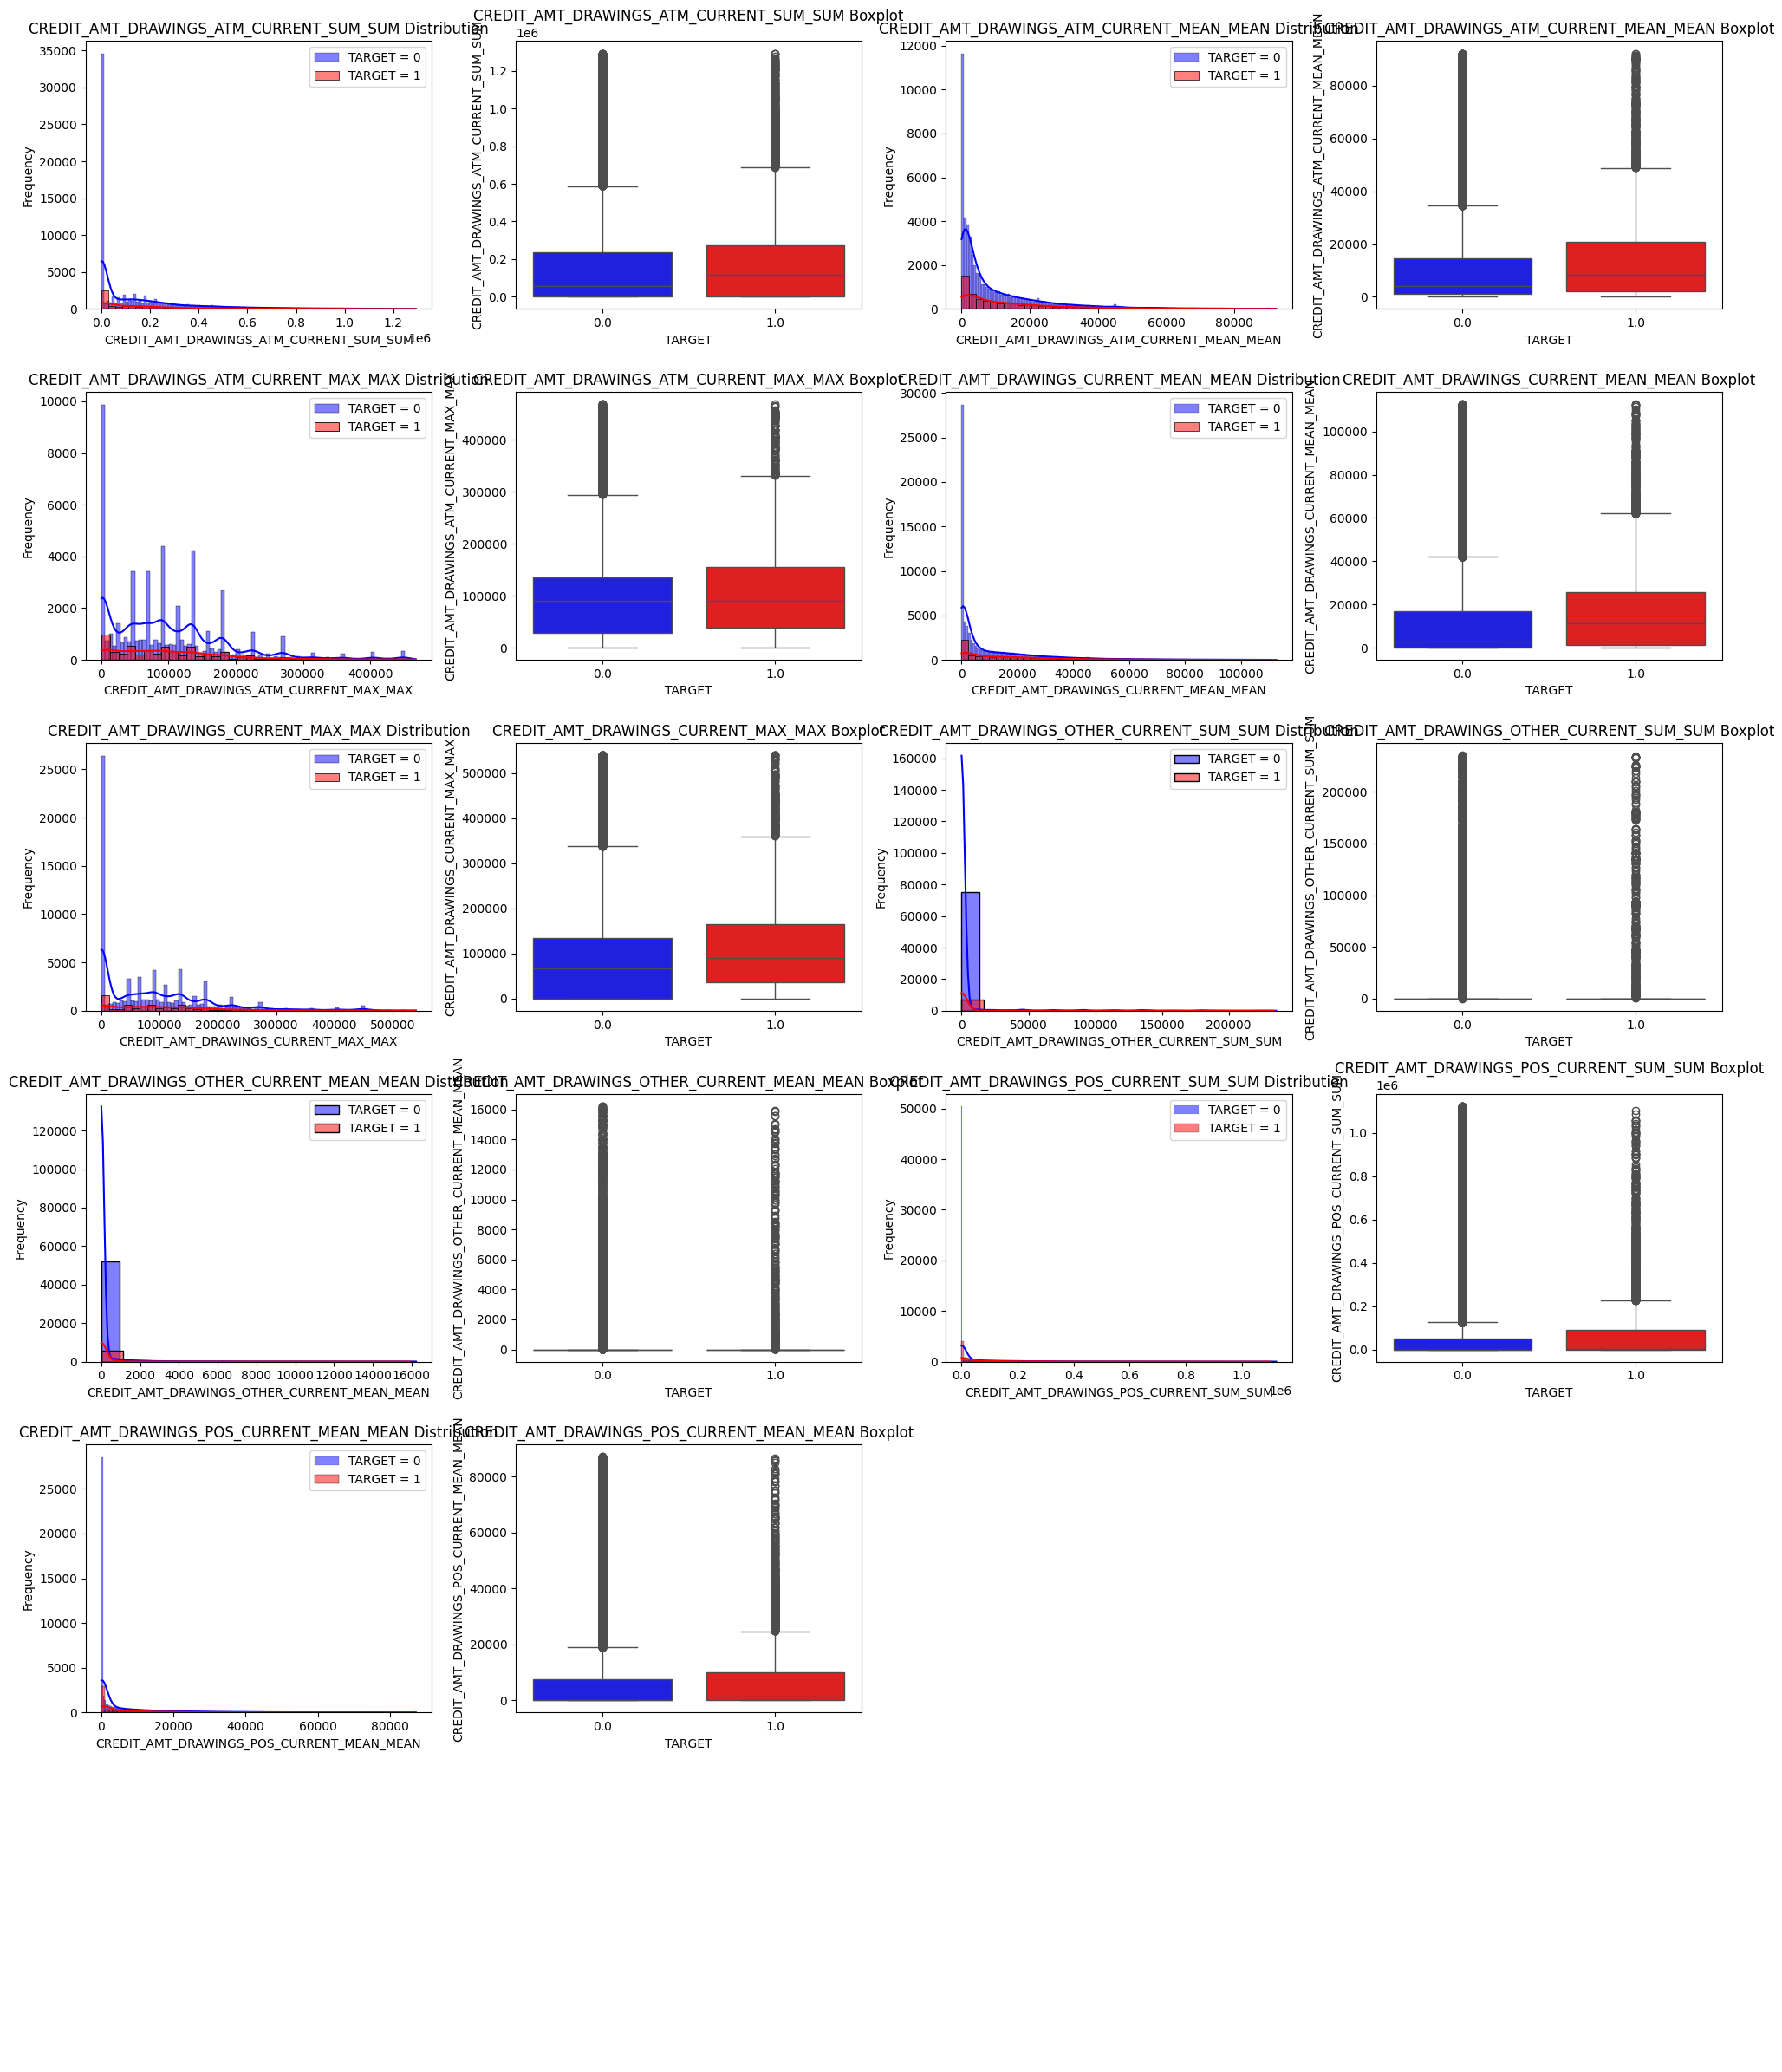

In [20]:
plot_multiple_numeric_dists(
    agg_credit,
    features = [
         'CREDIT_AMT_DRAWINGS_ATM_CURRENT_SUM_SUM',
         'CREDIT_AMT_DRAWINGS_ATM_CURRENT_MEAN_MEAN',
         'CREDIT_AMT_DRAWINGS_ATM_CURRENT_MAX_MAX',
         'CREDIT_AMT_DRAWINGS_CURRENT_MEAN_MEAN',
         'CREDIT_AMT_DRAWINGS_CURRENT_MAX_MAX',
         'CREDIT_AMT_DRAWINGS_OTHER_CURRENT_SUM_SUM',
         'CREDIT_AMT_DRAWINGS_OTHER_CURRENT_MEAN_MEAN',
         'CREDIT_AMT_DRAWINGS_POS_CURRENT_SUM_SUM',
         'CREDIT_AMT_DRAWINGS_POS_CURRENT_MEAN_MEAN'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
         'CREDIT_AMT_DRAWINGS_ATM_CURRENT_SUM_SUM',
         'CREDIT_AMT_DRAWINGS_ATM_CURRENT_MEAN_MEAN',
         'CREDIT_AMT_DRAWINGS_ATM_CURRENT_MAX_MAX',
         'CREDIT_AMT_DRAWINGS_CURRENT_MEAN_MEAN',
         'CREDIT_AMT_DRAWINGS_CURRENT_MAX_MAX',
         'CREDIT_AMT_DRAWINGS_OTHER_CURRENT_SUM_SUM',
         'CREDIT_AMT_DRAWINGS_OTHER_CURRENT_MEAN_MEAN',
         'CREDIT_AMT_DRAWINGS_POS_CURRENT_SUM_SUM',
         'CREDIT_AMT_DRAWINGS_POS_CURRENT_MEAN_MEAN'
    ],
    percentile =0.99
)

1. CREDIT_AMT_DRAWINGS_ATM_CURRENT_SUM_SUM: The distribution of CREDIT_AMT_DRAWINGS_ATM_CURRENT_SUM_SUM is highly right-skewed, with most values concentrated at the lower end. The boxplot indicates that TARGET=1 (defaults) clients tend to have slightly higher values compared to TARGET=0 (non-default) clients, but there are many outliers. The skewness and outliers should be handled for effective model use.
2. CREDIT_AMT_DRAWINGS_ATM_CURRENT_MAX_MAX: The distribution of CREDIT_AMT_DRAWINGS_ATM_CURRENT_MAX_MAX shows a high concentration of low values, with the presence of outliers. The boxplot demonstrates that TARGET=1 clients tend to have larger values of this feature compared to TARGET=0 clients, but the feature requires transformations to handle skewness and outliers.
3. CREDIT_AMT_DRAWINGS_ATM_CURRENT_MEAN_MEAN: The CREDIT_AMT_DRAWINGS_ATM_CURRENT_MEAN_MEAN feature also follows a right-skewed distribution. Clients with higher values in this feature tend to default (TARGET=1), which is noticeable in the boxplot where TARGET=1 clients have higher mean values. It is important to preprocess this feature by addressing the skewness and outliers.
4. CREDIT_AMT_DRAWINGS_OTHER_CURRENT_SUM_SUM: The distribution of CREDIT_AMT_DRAWINGS_OTHER_CURRENT_SUM_SUM is similarly right-skewed with high concentrations around 0. Clients with higher values of this feature are more likely to default. The boxplot shows a clear separation, with TARGET=1 clients having higher values on average, suggesting this feature could have predictive power if properly transformed.
5. CREDIT_AMT_DRAWINGS_OTHER_CURRENT_MEAN_MEAN: The CREDIT_AMT_DRAWINGS_OTHER_CURRENT_MEAN_MEAN distribution is right-skewed, and the boxplot shows that the mean values for TARGET=1 (defaults) are generally higher compared to TARGET=0 (non-default). The feature is highly indicative of default risk but would benefit from preprocessing to normalize or transform the values.
6. CREDIT_AMT_DRAWINGS_POS_CURRENT_SUM_SUM: The distribution of CREDIT_AMT_DRAWINGS_POS_CURRENT_SUM_SUM is highly right-skewed, with many values clustered around 0. The boxplot reveals that clients with higher values of this feature are more likely to default, with a distinct difference between TARGET=0 and TARGET=1. Again, this feature should be preprocessed to handle skewness and outliers effectively.
7. CREDIT_AMT_DRAWINGS_POS_CURRENT_MEAN_MEAN: The CREDIT_AMT_DRAWINGS_POS_CURRENT_MEAN_MEAN distribution also shows right-skewed behavior. The boxplot shows that TARGET=1 clients tend to have higher mean values compared to TARGET=0 clients, indicating its potential predictive value. Like the others, it needs transformation to optimize its contribution to the model.
8. CREDIT_AMT_DRAWINGS_POS_CURRENT_SUM_SUM: The distribution for this feature is highly right-skewed, and the boxplot shows a similar pattern to the others, with higher values for TARGET=1 (defaults). This feature may be valuable for the model but will require preprocessing for normalization and outlier management to improve its effectiveness.
9. CREDIT_AMT_DRAWINGS_POS_CURRENT_MEAN_MEAN: The distribution of CREDIT_AMT_DRAWINGS_POS_CURRENT_MEAN_MEAN is right-skewed, with a concentration of values at lower levels. Higher values of this feature correlate with defaults, as seen in the boxplot. Handling the skewness and outliers will improve its performance in a machine learning model.

#### Payment Features

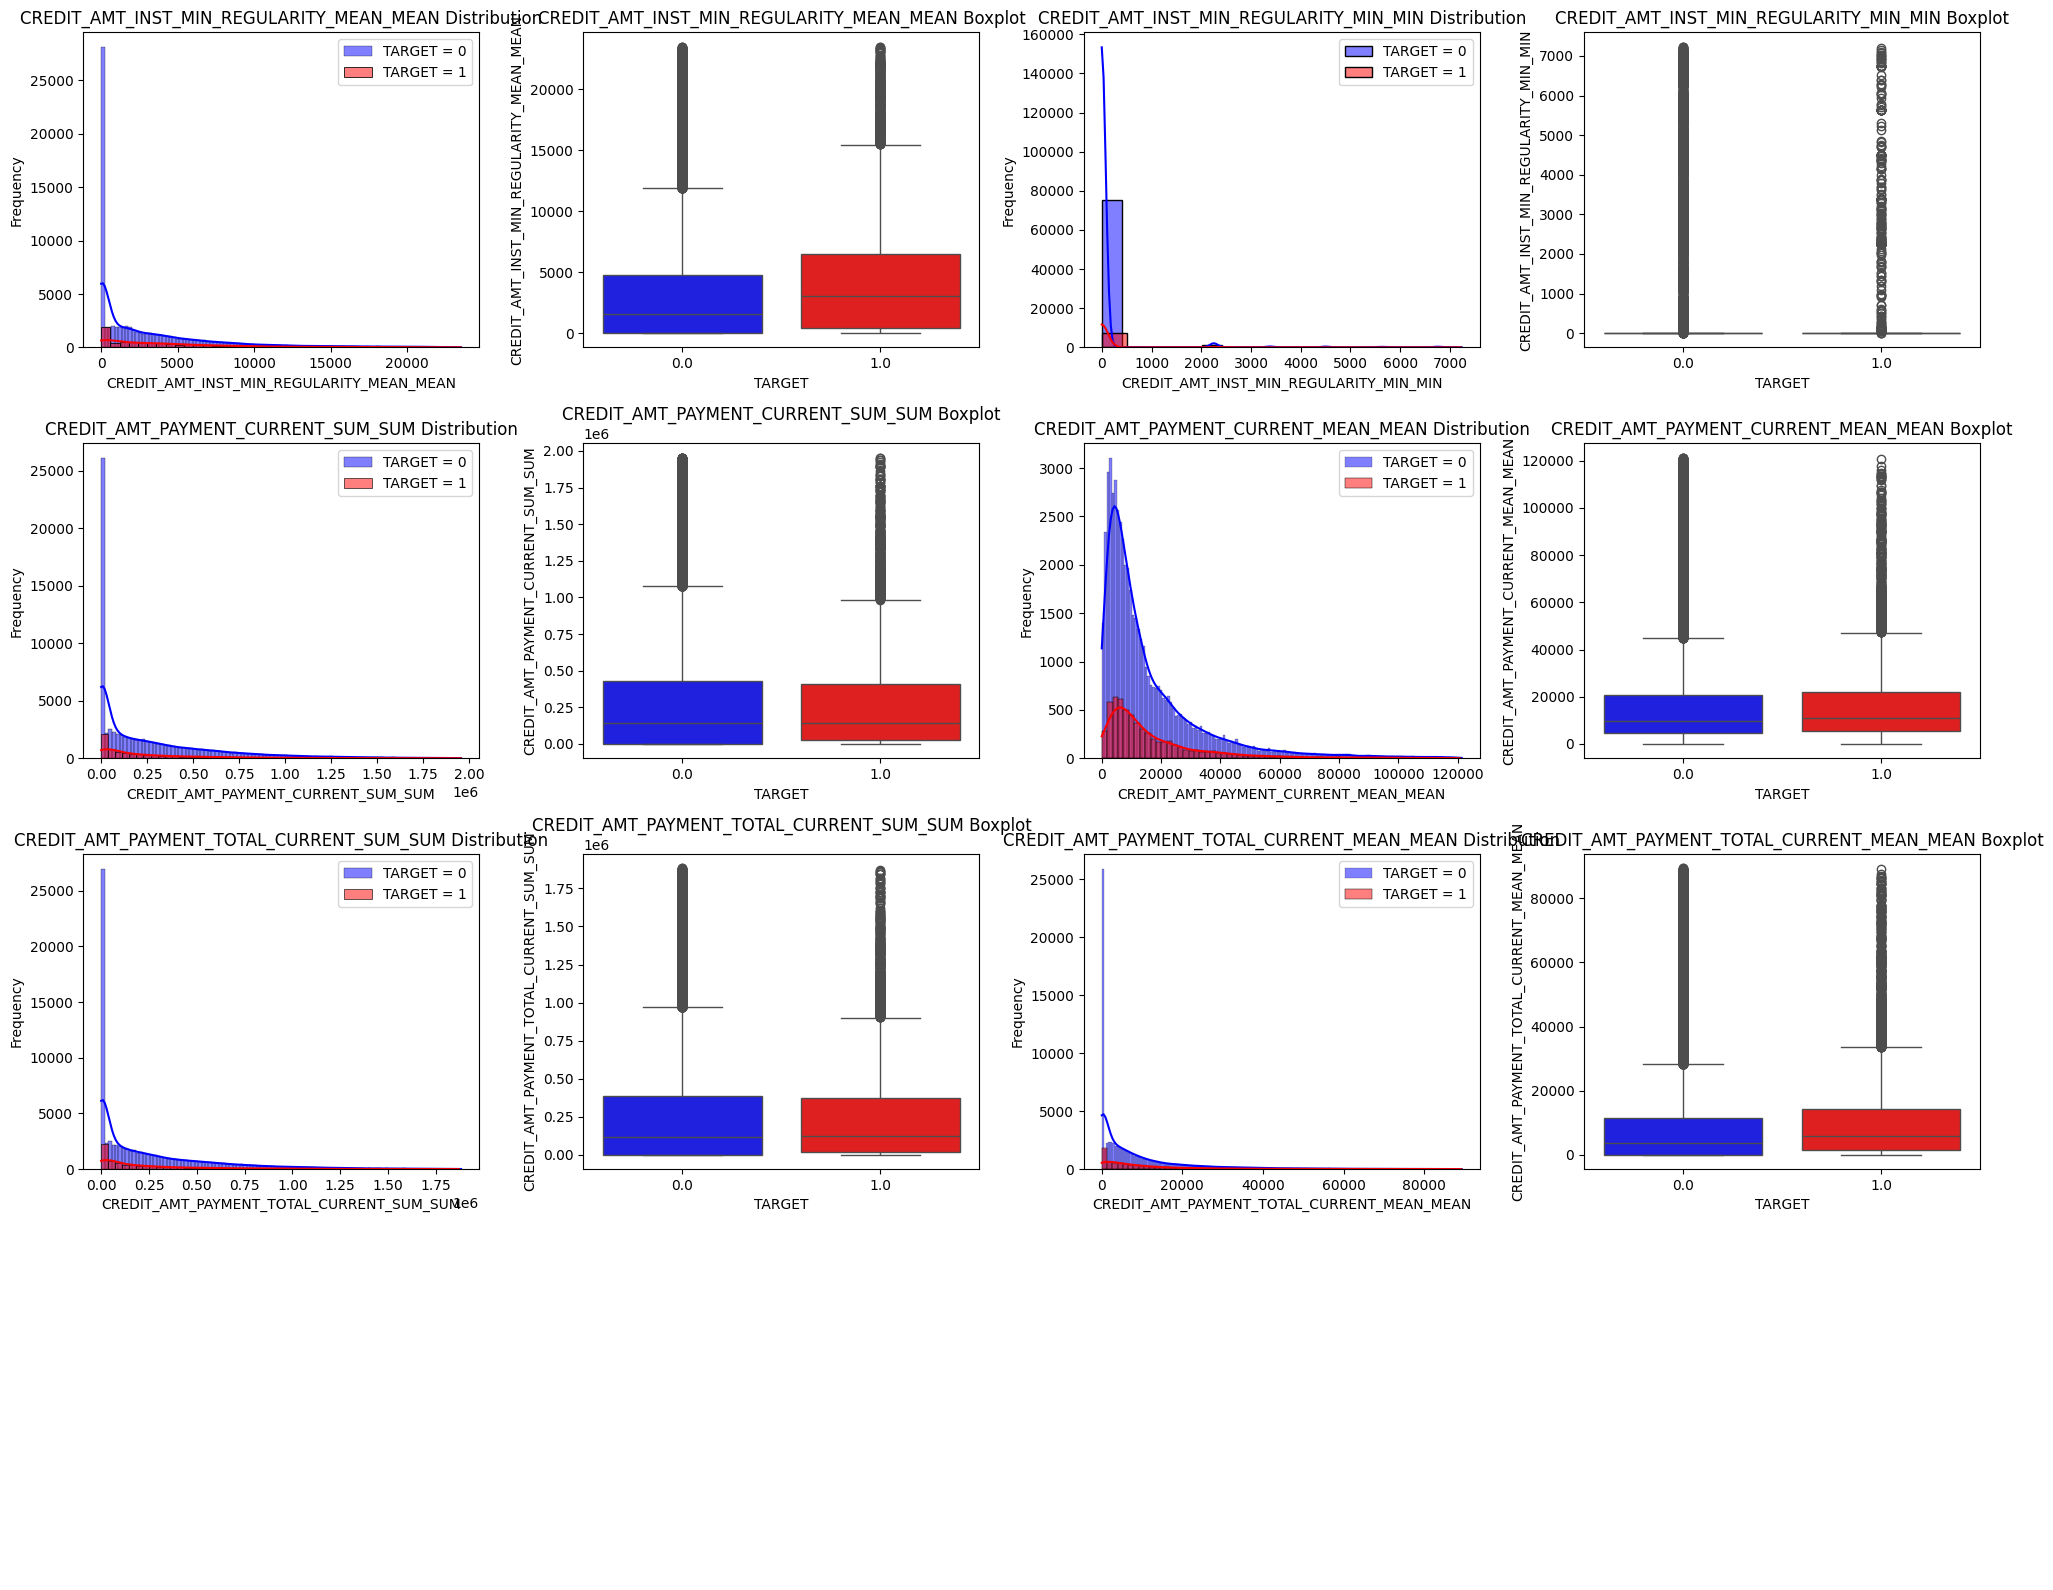

In [21]:
plot_multiple_numeric_dists(
    agg_credit,
    features = [
         'CREDIT_AMT_INST_MIN_REGULARITY_MEAN_MEAN',
         'CREDIT_AMT_INST_MIN_REGULARITY_MIN_MIN',
         'CREDIT_AMT_PAYMENT_CURRENT_SUM_SUM',
         'CREDIT_AMT_PAYMENT_CURRENT_MEAN_MEAN',
         'CREDIT_AMT_PAYMENT_TOTAL_CURRENT_SUM_SUM',
         'CREDIT_AMT_PAYMENT_TOTAL_CURRENT_MEAN_MEAN'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
         'CREDIT_AMT_INST_MIN_REGULARITY_MEAN_MEAN',
         'CREDIT_AMT_INST_MIN_REGULARITY_MIN_MIN',
         'CREDIT_AMT_PAYMENT_CURRENT_SUM_SUM',
         'CREDIT_AMT_PAYMENT_CURRENT_MEAN_MEAN',
         'CREDIT_AMT_PAYMENT_TOTAL_CURRENT_SUM_SUM',
         'CREDIT_AMT_PAYMENT_TOTAL_CURRENT_MEAN_MEAN'
    ],
    percentile =0.99
)

1. CREDIT_AMT_INST_MIN_REGULARITY_MEAN_MEAN: The CREDIT_AMT_INST_MIN_REGULARITY_MEAN_MEAN distribution is highly right-skewed with a large number of outliers. The boxplot indicates that clients with higher mean values (mostly associated with TARGET=1, defaults) tend to have higher values than non-default clients. Proper transformations such as log or square root may be required to handle the skewness and outliers.
2. CREDIT_AMT_INST_MIN_REGULARITY_MIN_MEAN: Similar to the previous feature, the CREDIT_AMT_INST_MIN_REGULARITY_MIN_MEAN distribution shows a sharp peak at low values, with many outliers. The boxplot shows a noticeable difference between TARGET=1 clients (defaults) and TARGET=0 clients (non-default), with defaults generally having higher values. Preprocessing to handle skewness would be beneficial.
3. CREDIT_AMT_PAYMENT_CURRENT_SUM_SUM: The CREDIT_AMT_PAYMENT_CURRENT_SUM_SUM distribution is highly right-skewed, with most values concentrated at the lower end. The boxplot also suggests that TARGET=1 clients (defaults) tend to have higher payment amounts on average compared to TARGET=0 clients. This feature may contain useful predictive power for defaults, but normalization or transformations would be necessary.
4. CREDIT_AMT_PAYMENT_CURRENT_MEAN_MEAN: This feature exhibits a right-skewed distribution, with TARGET=1 clients having larger values compared to TARGET=0 clients. The boxplot shows a clear difference between the two target classes, with TARGET=1 clients generally showing higher mean values. A logarithmic transformation could help mitigate the skew and enhance the feature's effectiveness in the model.
5. CREDIT_AMT_PAYMENT_TOTAL_CURRENT_SUM_SUM: The CREDIT_AMT_PAYMENT_TOTAL_CURRENT_SUM_SUM feature also follows a right-skewed distribution with many outliers. The boxplot indicates that TARGET=1 clients tend to have larger payment amounts compared to TARGET=0 clients, suggesting that this feature could be predictive of default risk. Preprocessing to handle the skew and outliers is recommended for better model performance.
6. CREDIT_AMT_PAYMENT_TOTAL_CURRENT_MEAN_MEAN: The distribution for CREDIT_AMT_PAYMENT_TOTAL_CURRENT_MEAN_MEAN is right-skewed, with higher payment amounts being more common for TARGET=1 clients (defaults). The boxplot supports this, with TARGET=1 clients having higher mean payment values. Similar to other features, handling the skew with transformations like log scaling would improve this feature's performance in a predictive model.

#### Receivable Features

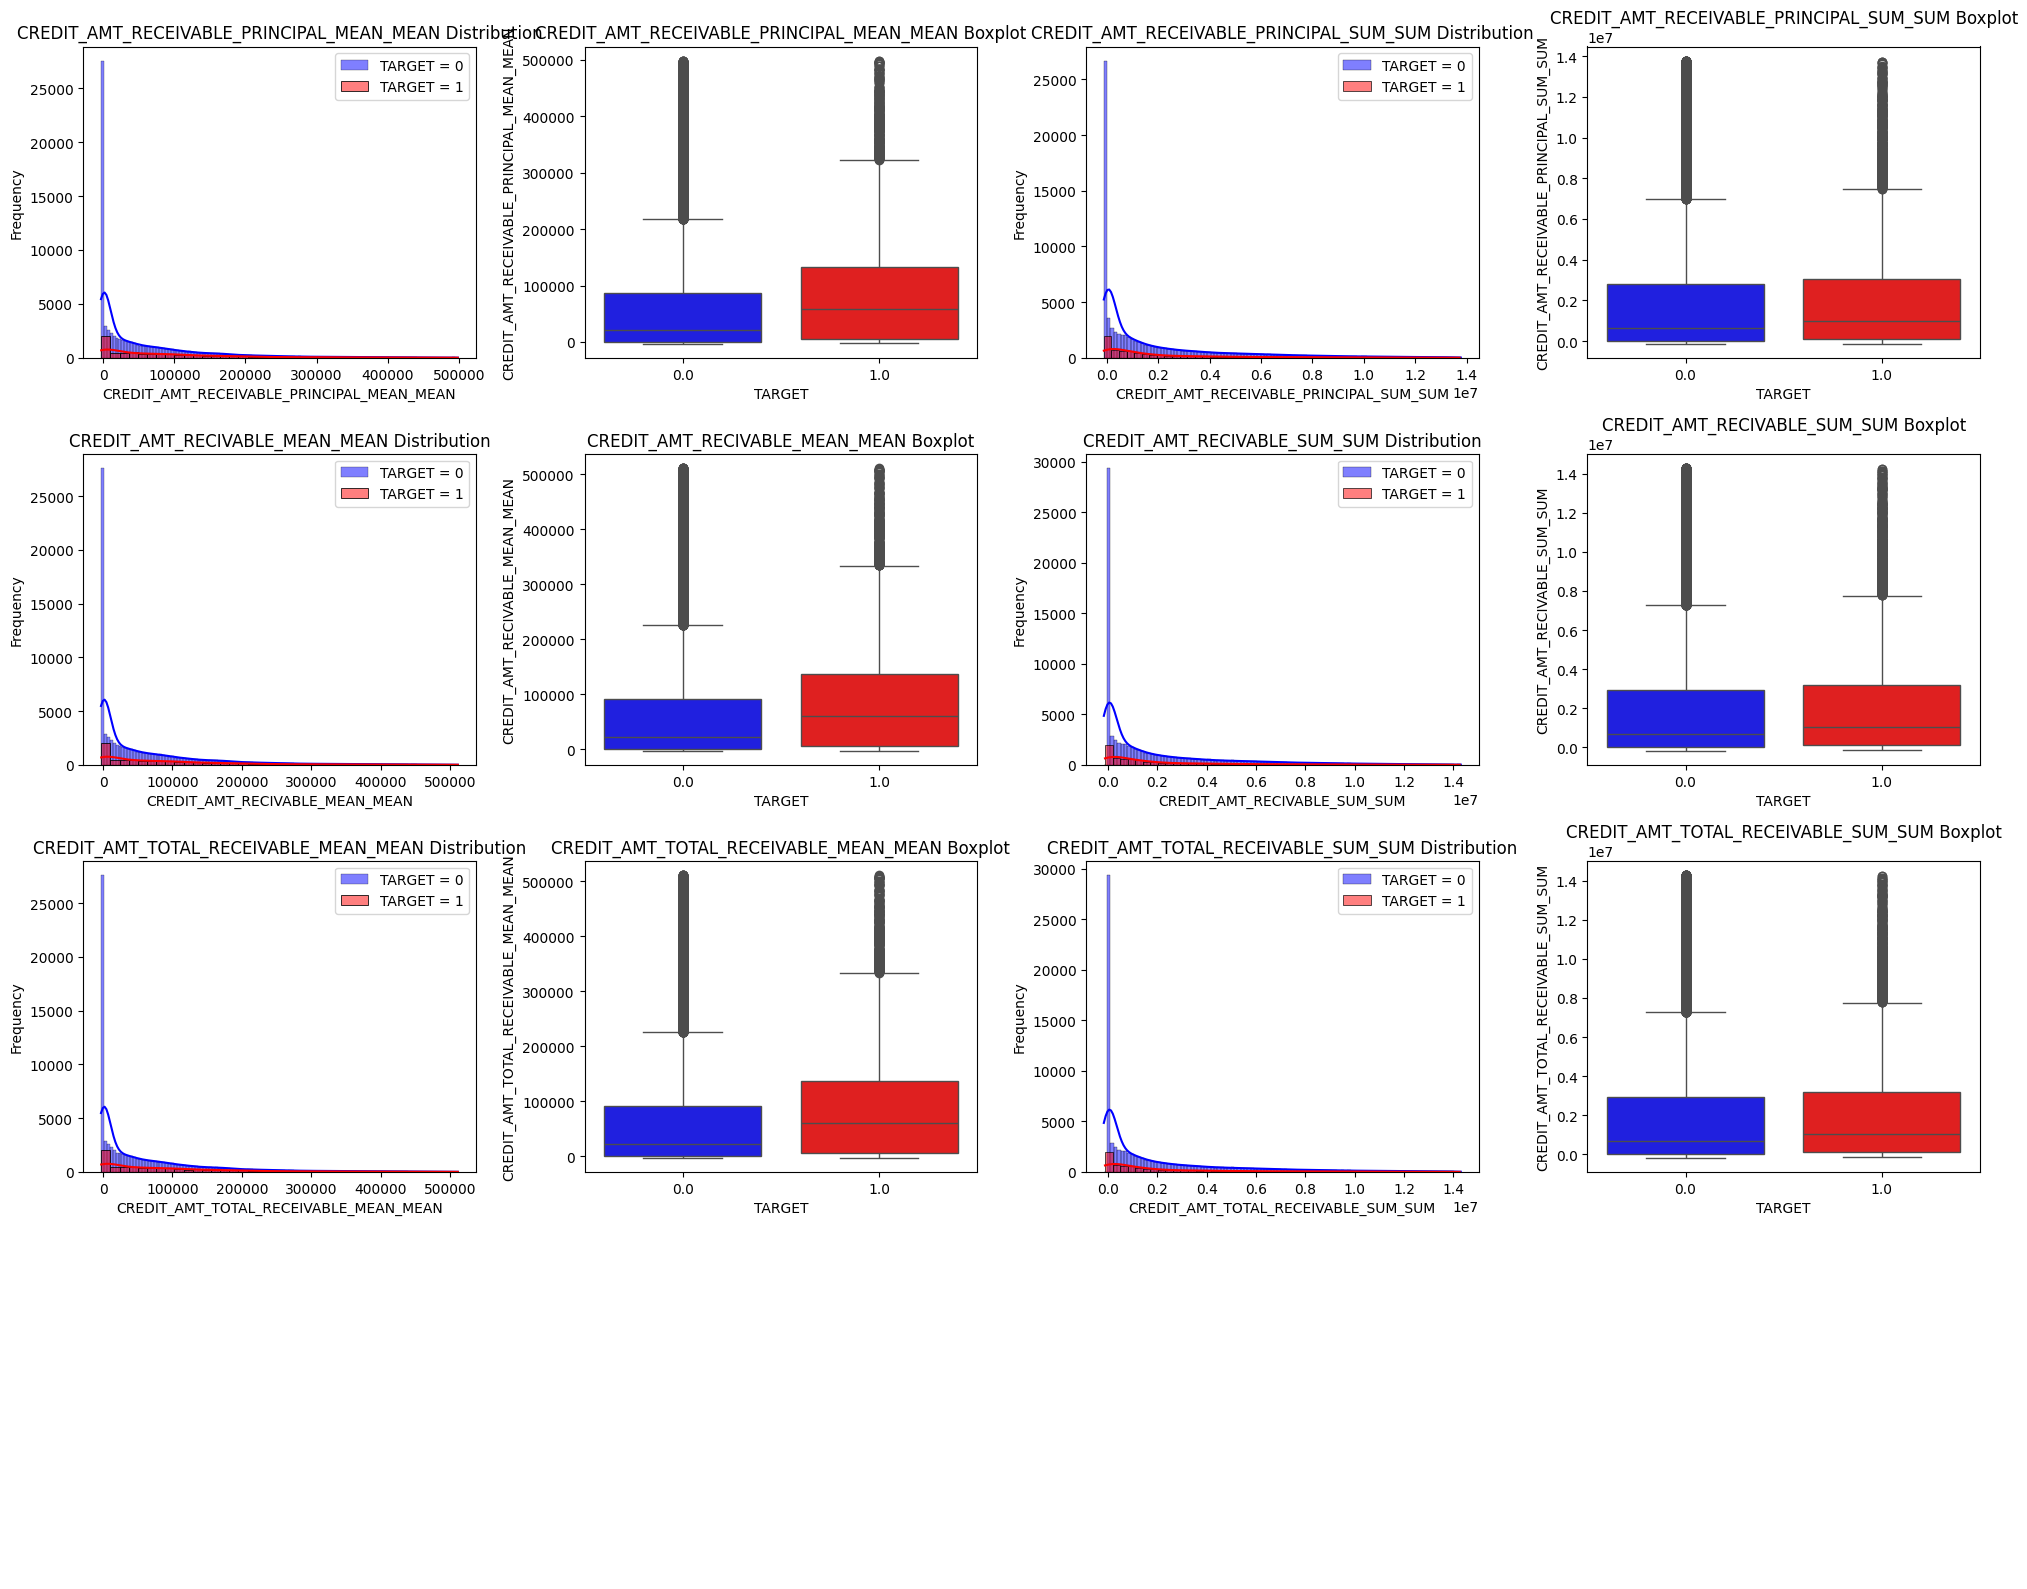

In [22]:
plot_multiple_numeric_dists(
    agg_credit,
    features = [
         'CREDIT_AMT_RECEIVABLE_PRINCIPAL_MEAN_MEAN',
         'CREDIT_AMT_RECEIVABLE_PRINCIPAL_SUM_SUM',
         'CREDIT_AMT_RECIVABLE_MEAN_MEAN',
         'CREDIT_AMT_RECIVABLE_SUM_SUM',
         'CREDIT_AMT_TOTAL_RECEIVABLE_MEAN_MEAN',
         'CREDIT_AMT_TOTAL_RECEIVABLE_SUM_SUM'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
         'CREDIT_AMT_RECEIVABLE_PRINCIPAL_MEAN_MEAN',
         'CREDIT_AMT_RECEIVABLE_PRINCIPAL_SUM_SUM',
         'CREDIT_AMT_RECIVABLE_MEAN_MEAN',
         'CREDIT_AMT_RECIVABLE_SUM_SUM',
         'CREDIT_AMT_TOTAL_RECEIVABLE_MEAN_MEAN',
         'CREDIT_AMT_TOTAL_RECEIVABLE_SUM_SUM'
    ],
    percentile =0.99
)

1. CREDIT_AMT_RECEIVABLE_PRINCIPAL_MEAN_MEAN: This feature has a right-skewed distribution, with most values clustered around lower values. The boxplot also reveals significant outliers, which are mostly associated with TARGET=1 (defaults). Clients who default tend to have higher mean principal amounts, which could potentially make this feature valuable for predicting defaults. A logarithmic transformation might be needed to handle the skew and outliers.
2. CREDIT_AMT_RECEIVABLE_MEAN_MEAN: Similar to the previous feature, CREDIT_AMT_RECEIVABLE_MEAN_MEAN shows a highly right-skewed distribution with large outliers, especially for TARGET=1 clients. The boxplot confirms that TARGET=1 clients tend to have higher mean receivables, making this feature another candidate for transformation to improve model performance.
3. CREDIT_AMT_RECEIVABLE_PRINCIPAL_SUM_SUM: The distribution of this feature is also right-skewed, and there are significant outliers visible in the boxplot. The pattern is similar to the previous features: TARGET=1 clients (defaults) tend to have larger sums. Again, this feature is potentially useful for default prediction but requires handling for the skew and outliers.
4. CREDIT_AMT_RECEIVABLE_SUM_SUM: The CREDIT_AMT_RECEIVABLE_SUM_SUM feature has a distribution with a strong peak at lower values and long right tail, indicating a skewed distribution. The boxplot indicates that TARGET=1 clients generally show higher values compared to TARGET=0. Transformations or normalization may be required for this feature to improve model performance.
5. CREDIT_AMT_TOTAL_RECEIVABLE_MEAN_MEAN: This feature exhibits a distribution that is again right-skewed, with TARGET=1 clients (defaults) having higher values on average compared to TARGET=0 clients. The boxplot shows clear outliers, particularly for TARGET=1. A logarithmic transformation or other preprocessing methods are recommended to handle the skew and outliers.
6. CREDIT_AMT_TOTAL_RECEIVABLE_SUM_SUM: Similar to other features, CREDIT_AMT_TOTAL_RECEIVABLE_SUM_SUM is right-skewed with a concentration of values at lower amounts. The boxplot indicates that TARGET=1 clients typically have larger total receivables. Again, preprocessing for skewness and outliers would improve the usability of this feature in predictive models.

#### Installment Features

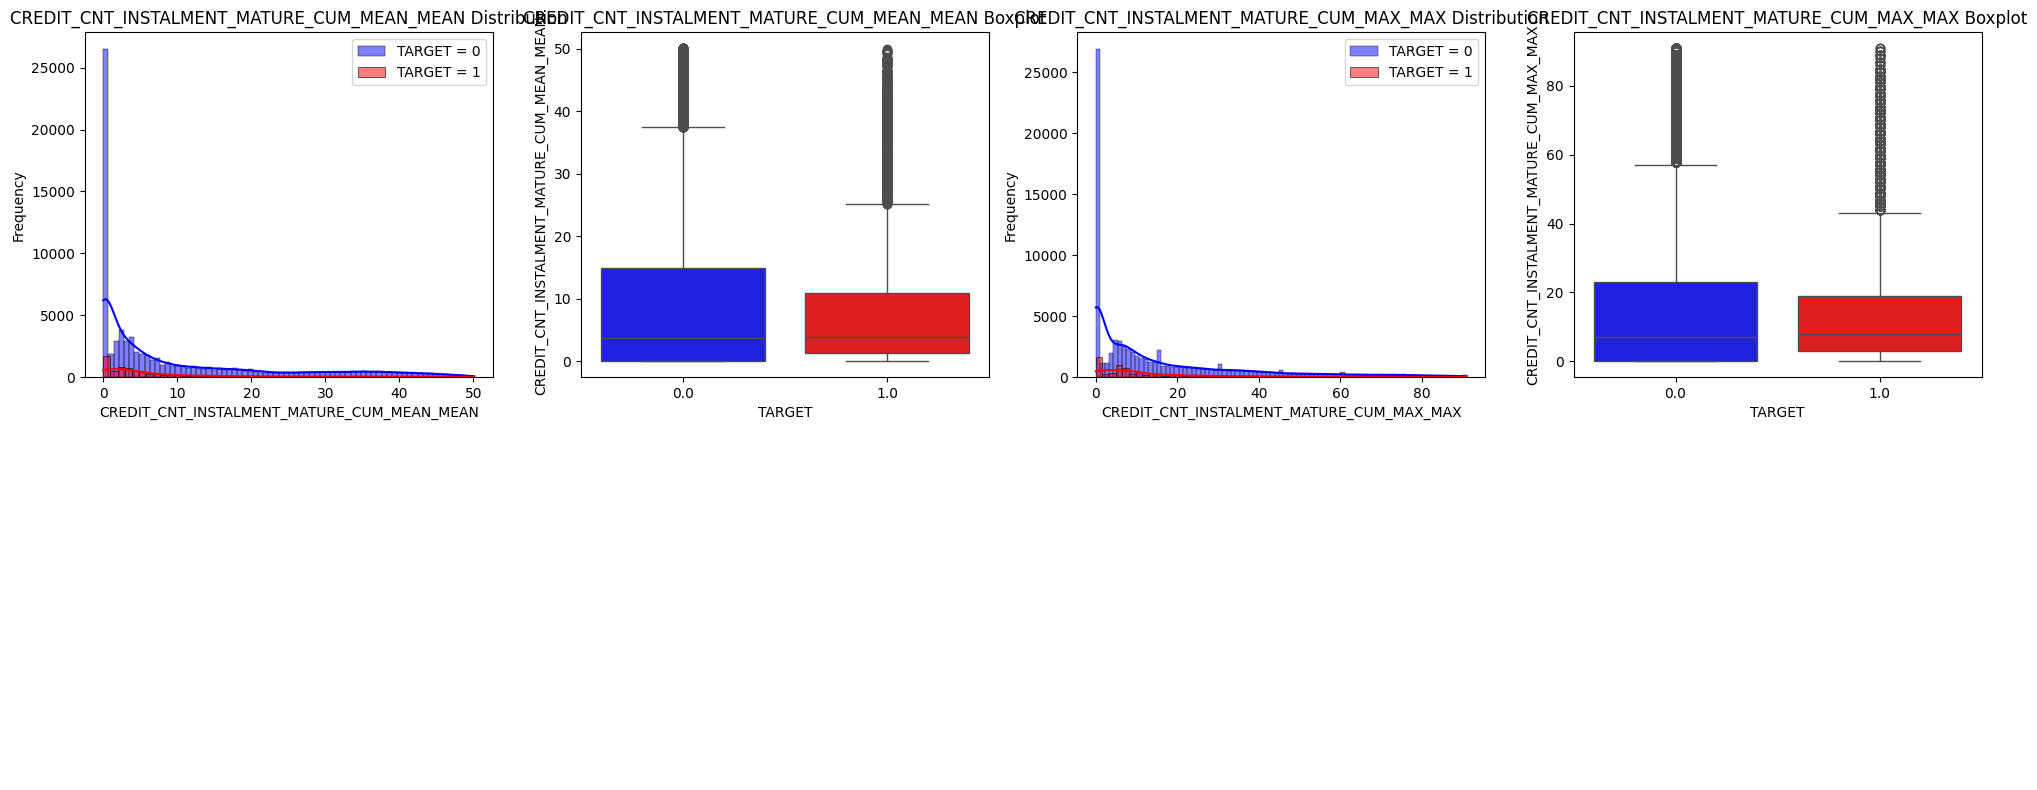

In [23]:
plot_multiple_numeric_dists(
    agg_credit,
    features = [
         'CREDIT_CNT_INSTALMENT_MATURE_CUM_MEAN_MEAN',
         'CREDIT_CNT_INSTALMENT_MATURE_CUM_MAX_MAX'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
         'CREDIT_CNT_INSTALMENT_MATURE_CUM_MEAN_MEAN',
         'CREDIT_CNT_INSTALMENT_MATURE_CUM_MAX_MAX'
    ],
    percentile =0.99
)

1. CREDIT_CNT_INSTALMENT_MATURE_CUM_MEAN_MEAN: This feature exhibits a highly skewed distribution, where the majority of the values are concentrated around lower amounts. The boxplot indicates that TARGET=0 clients have a larger concentration of values near the lower end of the scale, while TARGET=1 clients (defaults) show a slightly broader spread of values, with some outliers. The right-skewed nature suggests the need for transformation to make the feature more suitable for modeling.
2. CREDIT_CNT_INSTALMENT_MATURE_CUM_MAX_MAX: Similar to the previous feature, this one also has a highly skewed distribution with outliers, particularly for TARGET=1 clients. The boxplot confirms that TARGET=1 clients tend to have larger values in comparison to TARGET=0 clients. However, the presence of extreme outliers suggests that the feature could benefit from scaling or transformation to improve model performance.

#### Overdue (Days Past Due) Features

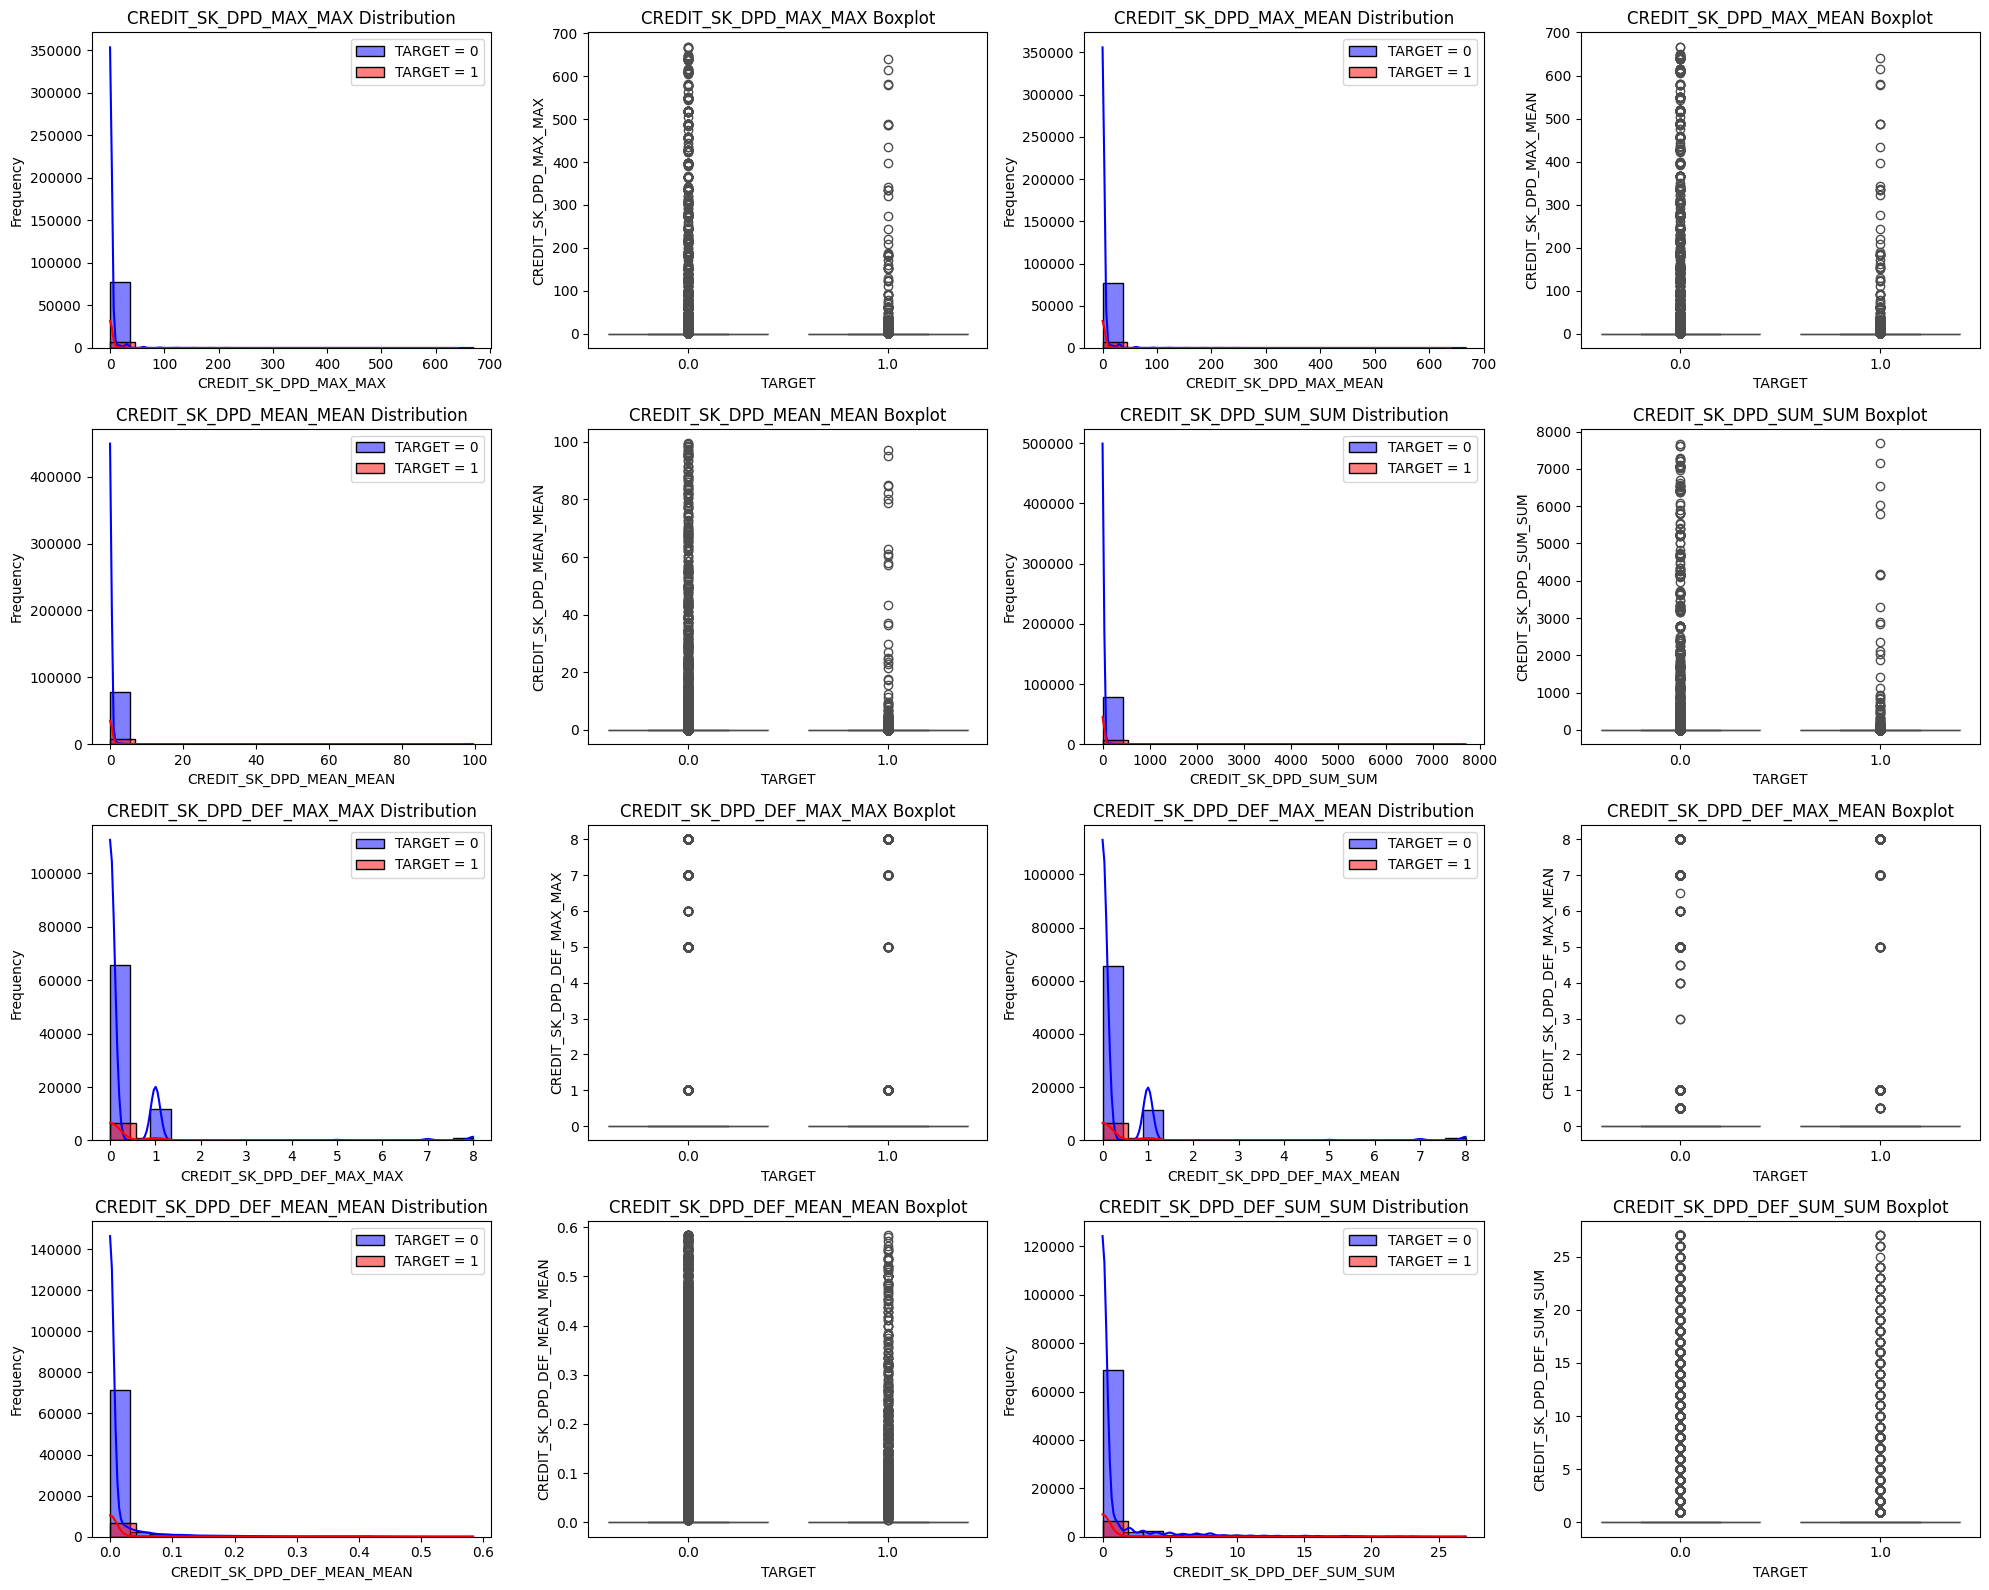

In [24]:
plot_multiple_numeric_dists(
    agg_credit,
    features = [
         'CREDIT_SK_DPD_MAX_MAX',
         'CREDIT_SK_DPD_MAX_MEAN',
         'CREDIT_SK_DPD_MEAN_MEAN',
         'CREDIT_SK_DPD_SUM_SUM',
         'CREDIT_SK_DPD_DEF_MAX_MAX',
         'CREDIT_SK_DPD_DEF_MAX_MEAN',
         'CREDIT_SK_DPD_DEF_MEAN_MEAN',
         'CREDIT_SK_DPD_DEF_SUM_SUM'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
         'CREDIT_SK_DPD_MAX_MAX',
         'CREDIT_SK_DPD_MAX_MEAN',
         'CREDIT_SK_DPD_MEAN_MEAN',
         'CREDIT_SK_DPD_SUM_SUM',
         'CREDIT_SK_DPD_DEF_MAX_MAX',
         'CREDIT_SK_DPD_DEF_MAX_MEAN',
         'CREDIT_SK_DPD_DEF_MEAN_MEAN',
         'CREDIT_SK_DPD_DEF_SUM_SUM'
    ],
    percentile =0.99
)

1. CREDIT_SK_DPD_MAX_MAX: The distribution is heavily right-skewed with a significant concentration at 0 for TARGET=0. For TARGET=1, there is a sharp increase in the number of observations in the higher range, suggesting that clients with defaults have a larger max value for days past due (DPD). The boxplot confirms the presence of extreme outliers, which may require further handling, such as transformation.
2. CREDIT_SK_DPD_MAX_MAX: The boxplot shows that for TARGET=0, most values are concentrated near the lower end of the scale (0-5), while TARGET=1 clients (defaults) have wider spread values, including extreme outliers. This suggests that the feature could benefit from scaling or outlier treatment.
3. CREDIT_SK_DPD_MAX_MEAN: The distribution again reveals a highly skewed pattern with a heavy concentration around low values. TARGET=1 clients have a slightly higher spread compared to TARGET=0 clients, with significant outliers present for the defaulting class.
4. CREDIT_SK_DPD_MAX_MEAN: The boxplot further corroborates the findings from the distribution. TARGET=1 clients have a wider range of values with many outliers, while TARGET=0 clients have a concentrated distribution near 0.
5. CREDIT_SK_DPD_SUM_MAX: The distribution shows that most values are concentrated at low values for TARGET=0. TARGET=1 clients (defaults) have a higher concentration in the higher range of this feature, indicating that a higher sum of DPD is associated with loan defaults.
6. CREDIT_SK_DPD_SUM_MAX: The boxplot reveals that TARGET=1 clients have values spread across a much wider range compared to TARGET=0 clients. Additionally, TARGET=1 clients have extreme outliers, which might indicate abnormal cases that could distort model training.
7. CREDIT_SK_DPD_DEF_MAX_MAX: The distribution is highly skewed, and TARGET=1 clients have a higher proportion of observations with higher values compared to TARGET=0 clients. This feature shows some important variation between the two groups.
8. CREDIT_SK_DPD_DEF_SUM_SUM: For TARGET=1, the distribution is heavily right-skewed with a long tail towards higher values, indicating that clients who default have a significantly higher cumulative sum of days past due than non-default clients. The boxplot also shows that TARGET=1 clients have extreme outliers, suggesting that outlier handling could be beneficial.


#### Contract Status Features

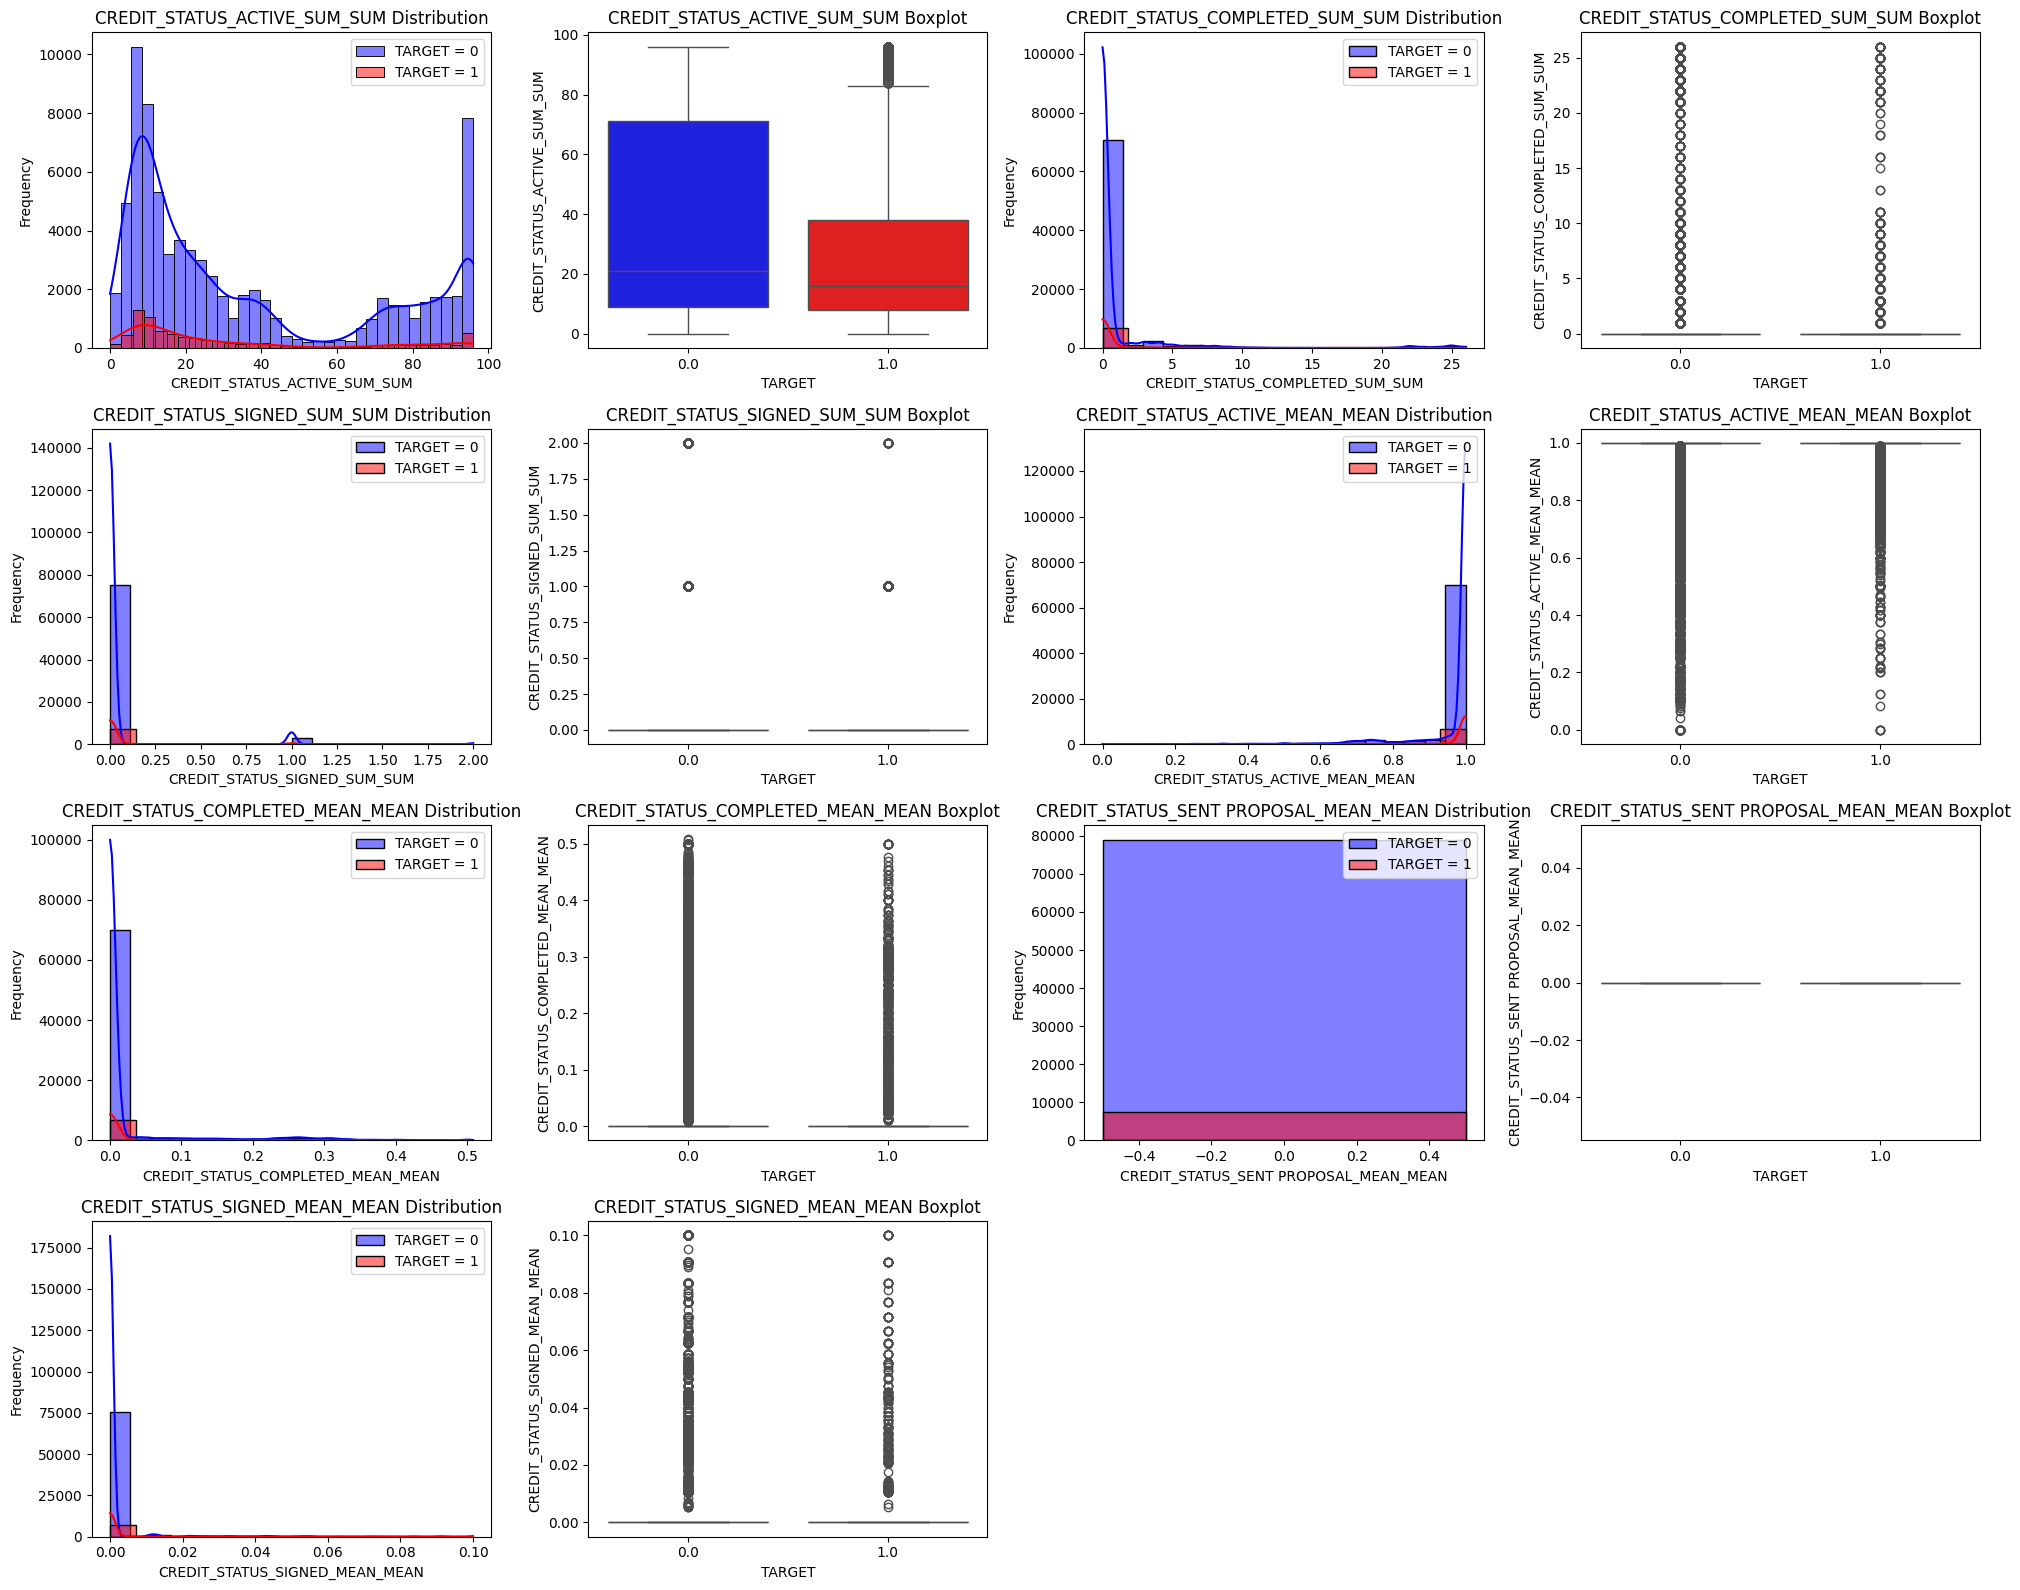

In [25]:
plot_multiple_numeric_dists(
    agg_credit,
    features = [
         'CREDIT_STATUS_ACTIVE_SUM_SUM',
         'CREDIT_STATUS_COMPLETED_SUM_SUM',
         'CREDIT_STATUS_SIGNED_SUM_SUM',
         'CREDIT_STATUS_ACTIVE_MEAN_MEAN',
         'CREDIT_STATUS_COMPLETED_MEAN_MEAN',
         'CREDIT_STATUS_SENT PROPOSAL_MEAN_MEAN',
         'CREDIT_STATUS_SIGNED_MEAN_MEAN'
    ],
    target = 'TARGET',
    remove_outliers = True,
    outlier_features = [
         'CREDIT_STATUS_ACTIVE_SUM_SUM',
         'CREDIT_STATUS_COMPLETED_SUM_SUM',
         'CREDIT_STATUS_SIGNED_SUM_SUM',
         'CREDIT_STATUS_ACTIVE_MEAN_MEAN',
         'CREDIT_STATUS_COMPLETED_MEAN_MEAN',
         'CREDIT_STATUS_SENT PROPOSAL_MEAN_MEAN',
         'CREDIT_STATUS_SIGNED_MEAN_MEAN'
    ],
    percentile =0.99
)

1. CREDIT_STATUS_ACTIVE_SUM_SUM: The distribution is highly skewed with most values concentrated at low levels, while TARGET = 1 has a slightly higher frequency for values near 0. The boxplot confirms that there are significant outliers for both target classes.
2. CREDIT_STATUS_SIGNED_SUM_SUM: This feature mostly has values near 0, with very few data points having a value near 1. The boxplot shows that TARGET = 0 and TARGET = 1 share similar distributions for this feature, but with high variance at values near 0.
3. CREDIT_STATUS_COMPLETED_SUM_SUM: The distribution is highly skewed, with most values being 0. Very few instances show non-zero values. The boxplot highlights the large concentration of data points around 0 for both target values, suggesting a low level of activity.
4. CREDIT_STATUS_ACTIVE_MEAN_MEAN: Similar to other features, the distribution is dominated by values near 0, with a few outliers. The boxplot shows significant outliers for both target classes, although there is no substantial difference in central tendency between TARGET = 0 and TARGET = 1.
5. CREDIT_STATUS_COMPLETED_MEAN_MEAN: This feature has a highly concentrated distribution with values close to 0, with some positive outliers. The boxplot again confirms a concentration near 0 for both target classes, with a few outliers on the higher end.
6. CREDIT_STATUS_SIGNED_MEAN_MEAN: The distribution is concentrated around 0 with a small number of outliers. For both target classes, the data shows significant variance, especially for TARGET = 1, with a few data points reaching the higher values in the distribution.
7. CREDIT_STATUS_SENT_PROPOSAL_MEAN_MEAN: This feature has very few non-zero values, and the distribution shows a peak near 0. The boxplot confirms that TARGET = 0 has a higher concentration around 0 compared to TARGET = 1, with TARGET = 1 showing a few scattered non-zero points.

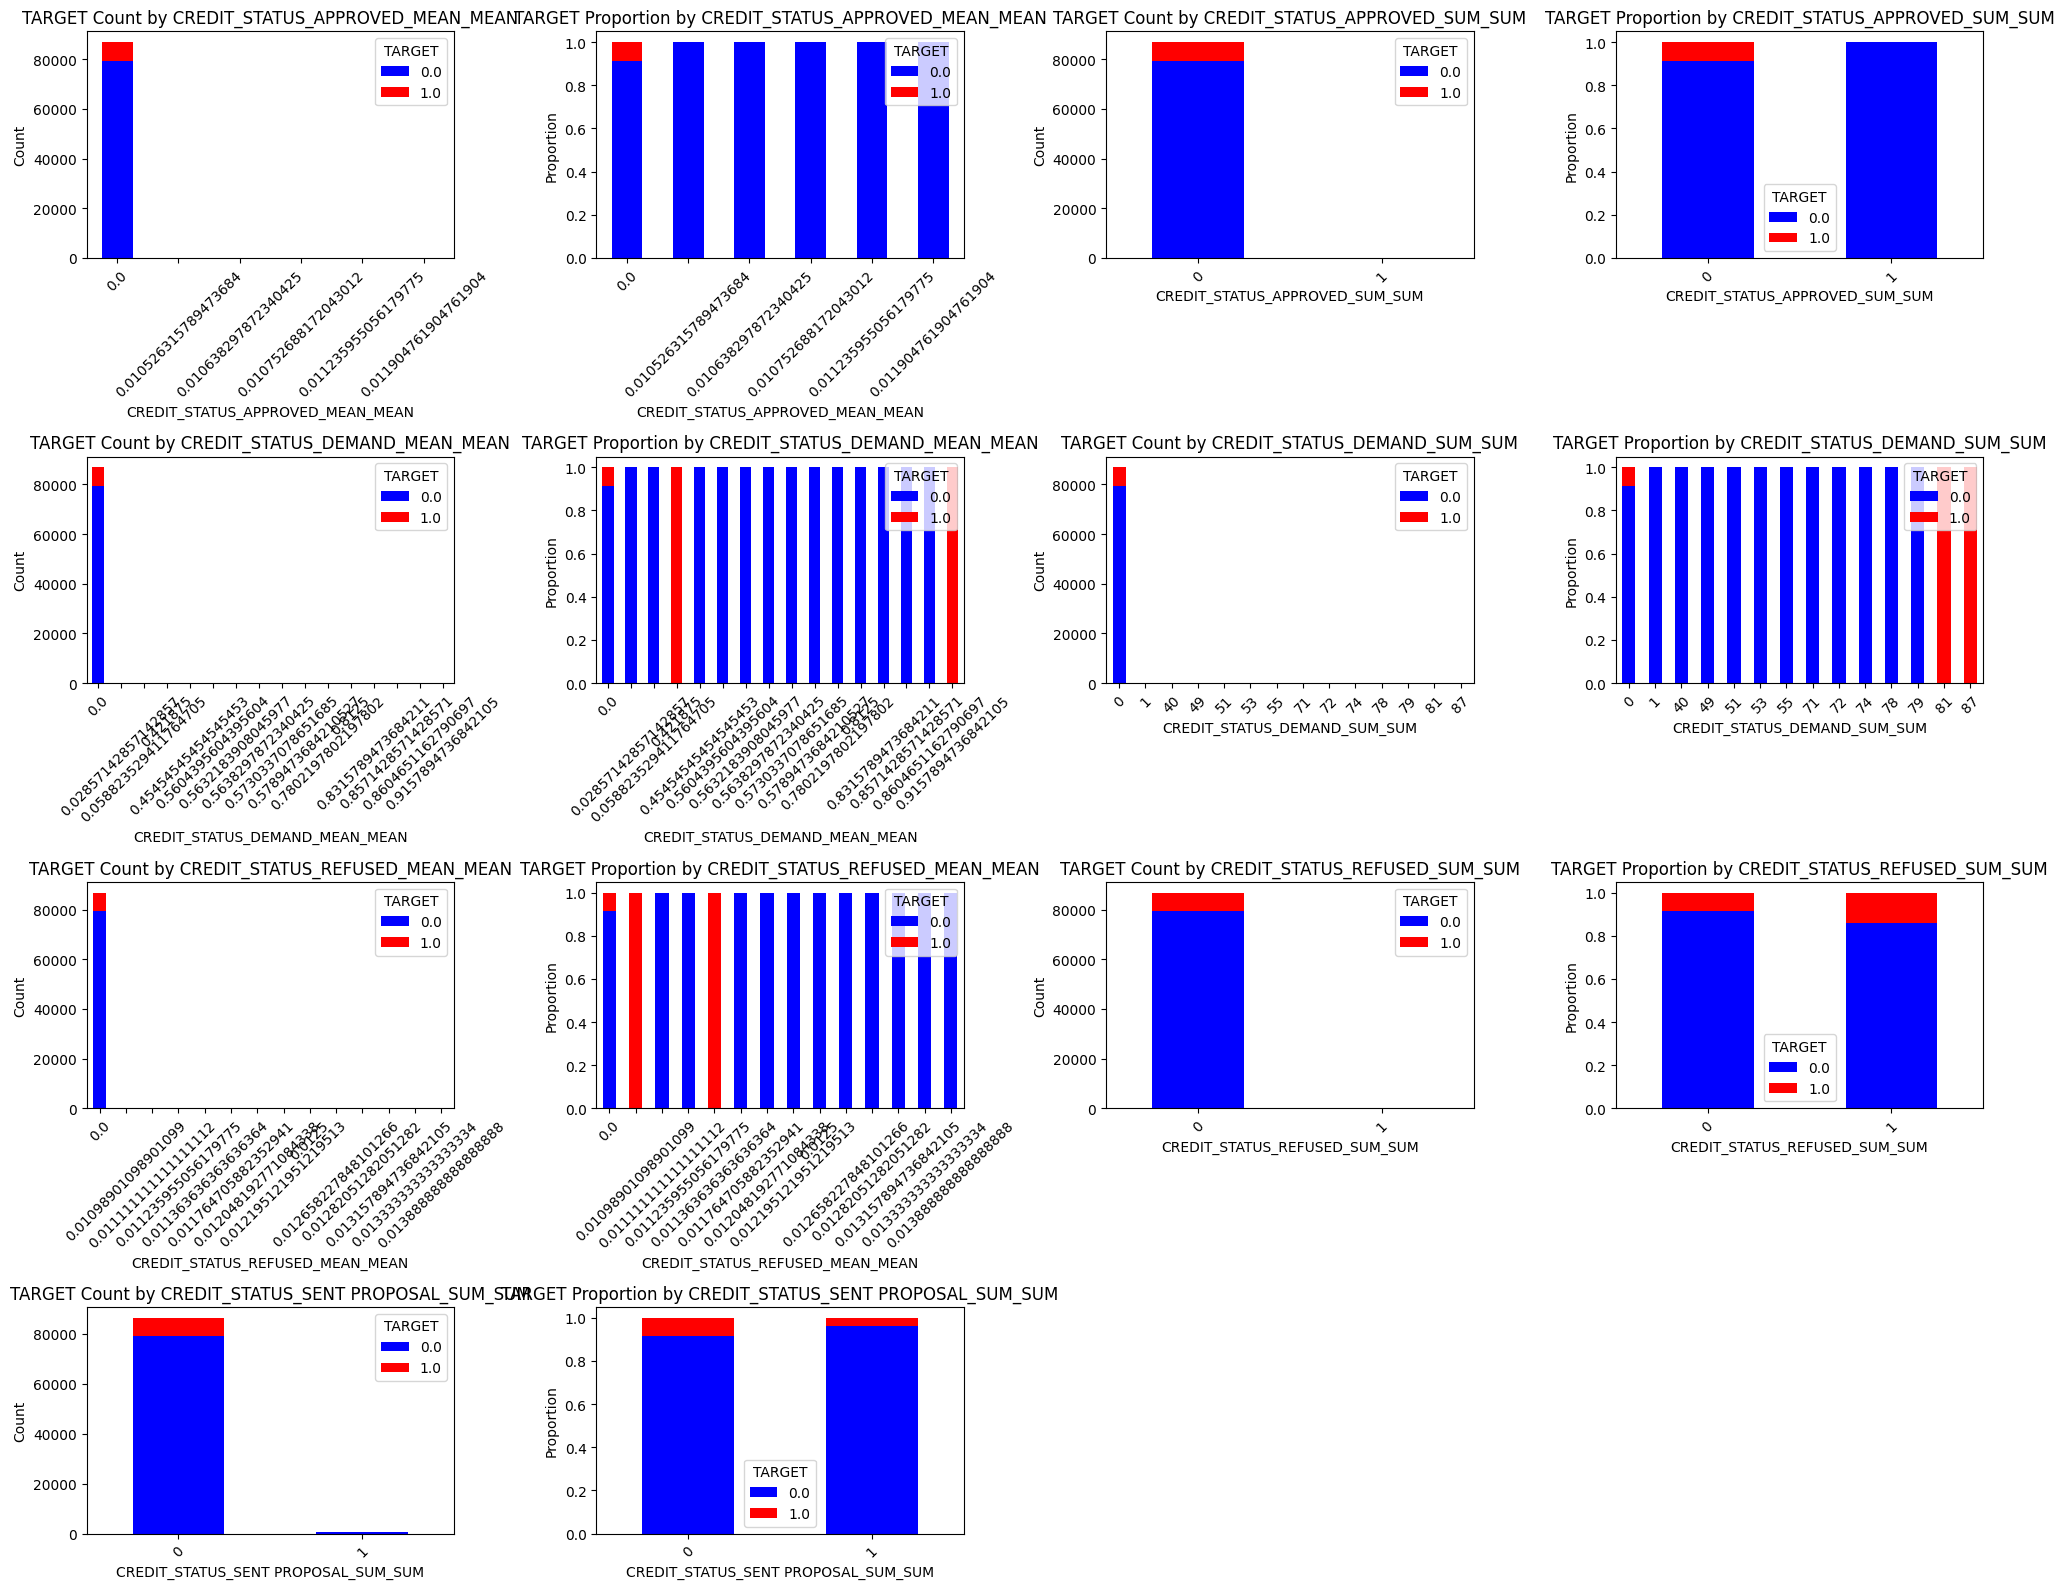

In [26]:
plot_multiple_categorical_dists(
    agg_credit,
    features = [
        'CREDIT_STATUS_APPROVED_MEAN_MEAN',
        'CREDIT_STATUS_APPROVED_SUM_SUM',
        'CREDIT_STATUS_DEMAND_MEAN_MEAN',
        'CREDIT_STATUS_DEMAND_SUM_SUM',
        'CREDIT_STATUS_REFUSED_MEAN_MEAN',
        'CREDIT_STATUS_REFUSED_SUM_SUM',
        'CREDIT_STATUS_SENT PROPOSAL_SUM_SUM'
        ],
    target = 'TARGET'
    )

1. CREDIT_STATUS_APPROVED_MEAN_MEAN: The distribution is highly skewed with most values concentrated at 0, with very few higher values. The boxplot confirms this distribution, and the proportion plot shows a higher concentration of TARGET = 0 at value 0, suggesting little variation.
2. CREDIT_STATUS_APPROVED_SUM_SUM: This feature has a similar distribution to the previous one, with the values mainly concentrated around 0. The boxplot further reinforces this concentration, with both target classes showing very few non-zero values.
3. CREDIT_STATUS_DEMAND_MEAN_MEAN: Most of the data points are concentrated around 0, with very few instances showing any variation in the distribution. The boxplot also confirms this with the majority of the data points near 0 for both target classes.
4. CREDIT_STATUS_DEMAND_SUM_SUM: Similar to the previous features, this feature has a skewed distribution where most values are near 0, and the boxplot confirms very few high values. Both target classes show similar patterns of concentration around 0.
5. CREDIT_STATUS_REFUSED_MEAN_MEAN: The distribution shows a highly concentrated peak around 0, with few data points showing higher values. Both target classes exhibit similar patterns with little variation, as seen in the boxplot.
6. CREDIT_STATUS_REFUSED_SUM_SUM: The distribution is highly concentrated at 0, and the boxplot highlights this with most values near 0. The proportion plot indicates that TARGET = 0 is much more prevalent at value 0 compared to TARGET = 1.
7.CREDIT_STATUS_SENT_PROPOSAL_SUM_SUM: This feature shows a similar distribution with most values at 0, with very few higher values. Both target classes have a similar concentration of values near 0, and the boxplot reinforces this observation.

# Feature Importance and Selection

Feature selection involves choosing features with an importance score above 0.8. If two features have similar importance, the one with the higher score is kept. Features with zero importance are removed to simplify the dataset. After selecting these features, the LightGBM model is retrained. Finally, the model's accuracy and ROC-AUC score are checked to see how the selected features affect its performance.

#### Preparing the Data

In [27]:
agg_credit = agg_credit[agg_credit['TARGET'].notnull()]
X = agg_credit.drop(columns=['TARGET', 'SK_ID_CURR'], axis=1)
y = agg_credit['TARGET']

#### Splitting the Data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Training the Initial LightGBM Model

In [29]:
lgb_model = LGBMClassifier(is_unbalance=True, objective='binary', metric='auc')
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6027, number of negative: 63497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11509
[LightGBM] [Info] Number of data points in the train set: 69524, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086689 -> initscore=-2.354743
[LightGBM] [Info] Start training from score -2.354743


LGBMClassifier(is_unbalance=True, metric='auc', objective='binary')

In [30]:
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

#### Evaluating the Model

In [31]:
from sklearn.metrics import classification_report
print("Classification Report (All Features):")
print(classification_report(y_test, y_pred))

Classification Report (All Features):
              precision    recall  f1-score   support

         0.0       0.94      0.75      0.84     15874
         1.0       0.16      0.48      0.24      1507

    accuracy                           0.73     17381
   macro avg       0.55      0.62      0.54     17381
weighted avg       0.87      0.73      0.78     17381



The model catches 60% of defaulters (recall = 0.48), which is okey. However, the F1-score is low (0.24), meaning it predicts many false defaulters. So, while recall is strong, precision could need some improvement.

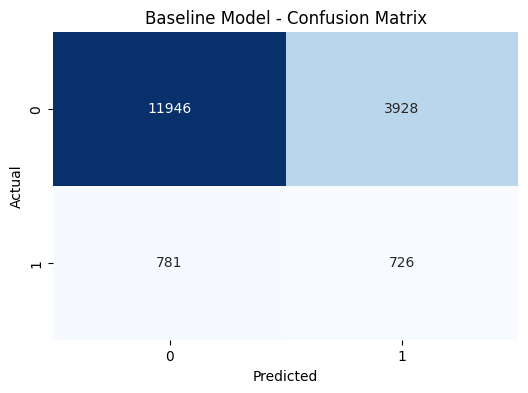

In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Baseline Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix shows that the model correctly predicted 11,816 non-defaulters and 708 defaulters. However, it also misclassified 3,764 non-defaulters as defaulters and missed 755 actual defaulters. This matches the earlier metrics: good at finding defaulters, but still mislabels many who would repay.

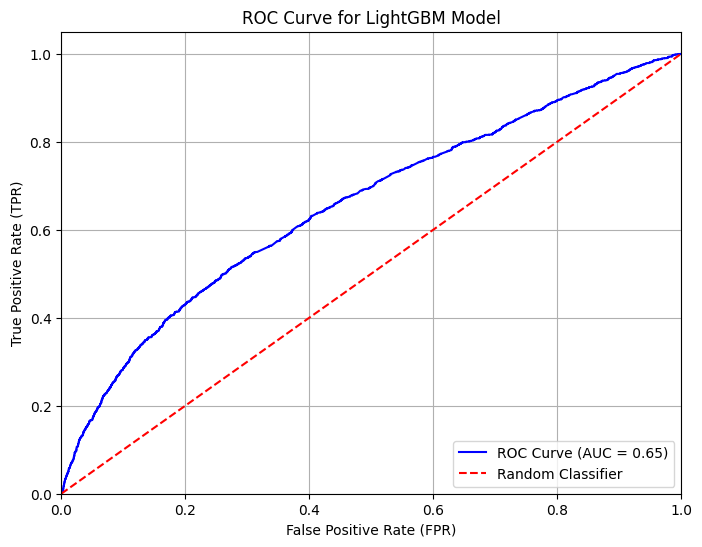

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for LightGBM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The ROC curve shows that the model performs better than random guessing, with an AUC of 0.65. This means it has a fair ability to distinguish between defaulters and non-defaulters, but there’s still room for improvement to reach stronger predictive power.

#### Calculate Feature Importance

In [34]:
importances = lgb_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

#### Compute the Correlation Matrix

In [35]:
corr_matrix = X_train.corr().abs()

#### Identify and Remove Redundant Features

In [36]:
high_corr_pairs = []
threshold = 0.8
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

features_to_remove = set()
for feat1, feat2 in high_corr_pairs:
    imp1 = feature_importance_df.loc[feature_importance_df['feature'] == feat1, 'importance'].values[0]
    imp2 = feature_importance_df.loc[feature_importance_df['feature'] == feat2, 'importance'].values[0]
    if imp1 > imp2:
        features_to_remove.add(feat2)
    else:
        features_to_remove.add(feat1)

#### Removing the features with the lower importance score

In [37]:
low_imp_threshold = 0
low_importance_features = feature_importance_df[feature_importance_df['importance'] < low_imp_threshold]['feature']
features_to_remove.update(low_importance_features)

#### Retraining and evaluating the LightGBM model using only selected features

In [38]:
selected_features = [feat for feat in feature_names if feat not in features_to_remove]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

lgb_model.fit(X_train_selected, y_train)
y_pred = lgb_model.predict(X_test_selected)
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6027, number of negative: 63497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5359
[LightGBM] [Info] Number of data points in the train set: 69524, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086689 -> initscore=-2.354743
[LightGBM] [Info] Start training from score -2.354743
              precision    recall  f1-score   support

         0.0       0.94      0.75      0.84     15874
         1.0       0.16      0.49      0.24      1507

    accuracy                           0.73     17381
   macro avg       0.55      0.62      0.54     17381
weighted avg       0.87      0.73      0.78     17381



For class 1, recall slightly improved (form 0.48 to 0.49), while F1-score slightly decreased (from 0.24 to 0.23) after feature selection.

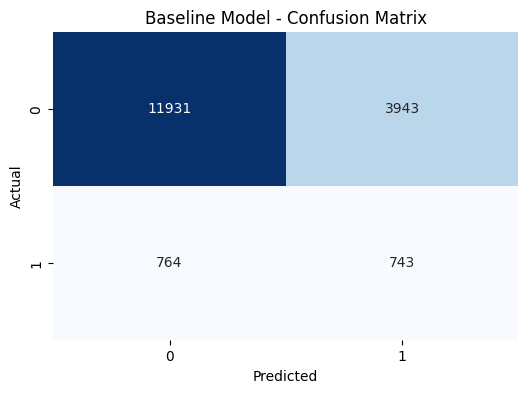

In [39]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Baseline Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The number of true positives and false negatives slightly changed after feature selection (712 vs. 708 and 11,669 vs. 11,816), showing a nearly identical prediction pattern with reduced feature complexity.

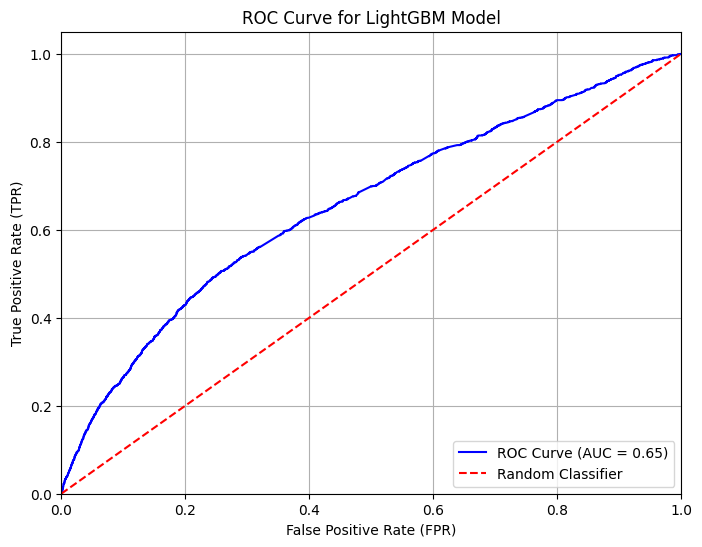

In [40]:
y_pred_proba = lgb_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for LightGBM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The AUC remains at 0.65, showing that the model's ability to distinguish between defaulters and non-defaulters has not changed after reducing the number of features. This means feature selection helped simplify the model without hurting its performance.

# Conclusion

To prepare the data for modeling, we aggregated the credit_card_balance dataset features, which helped reduce the size and complexity of the input for the machine learning model.

We used the LightGBM classifier with is_unbalance=True to handle the imbalanced target variable. This choice aligns with the competition’s final model setup, keeping our approach consistent.

## Feature Engineering and Selection

* After creating new features from both datasets, we checked their value by using a machine learning model.
* We used feature importance scores to select the most useful features and dropped the ones that didn’t help (importance = 0).
* We also compared similar features and kept only the better ones.

After applying feature selection, we removed the least important features listed in features_to_remove:

In [41]:
features_to_remove

{'CREDIT_AMT_BALANCE_MEAN_MAX',
 'CREDIT_AMT_BALANCE_MEAN_MEAN',
 'CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MAX_MAX',
 'CREDIT_AMT_DRAWINGS_CURRENT_MAX_MAX',
 'CREDIT_AMT_DRAWINGS_CURRENT_MEAN_MEAN',
 'CREDIT_AMT_DRAWINGS_CURRENT_SUM_SUM',
 'CREDIT_AMT_DRAWINGS_OTHER_CURRENT_SUM_SUM',
 'CREDIT_AMT_DRAWINGS_POS_CURRENT_SUM_SUM',
 'CREDIT_AMT_INST_MIN_REGULARITY_MEAN_MEAN',
 'CREDIT_AMT_PAYMENT_CURRENT_SUM_SUM',
 'CREDIT_AMT_PAYMENT_TOTAL_CURRENT_MEAN_MEAN',
 'CREDIT_AMT_RECEIVABLE_PRINCIPAL_MEAN_MEAN',
 'CREDIT_AMT_RECEIVABLE_PRINCIPAL_SUM_SUM',
 'CREDIT_AMT_RECIVABLE_MEAN_MEAN',
 'CREDIT_AMT_RECIVABLE_SUM_SUM',
 'CREDIT_AMT_TOTAL_RECEIVABLE_MEAN_MEAN',
 'CREDIT_AMT_TOTAL_RECEIVABLE_SUM_SUM',
 'CREDIT_CNT_DRAWINGS_POS_CURRENT_MEAN_MEAN',
 'CREDIT_CNT_DRAWINGS_POS_CURRENT_SUM_SUM',
 'CREDIT_CNT_INSTALMENT_MATURE_CUM_MAX_MAX',
 'CREDIT_MONTHS_BALANCE_COUNT_MAX',
 'CREDIT_MONTHS_BALANCE_COUNT_MEAN',
 'CREDIT_SK_DPD_DEF_MAX_MAX',
 'CREDIT_SK_DPD_DEF_MAX_MEAN',
 'CREDIT_SK_DPD_DEF_SUM_SUM',
 'CREDIT_S

### Final Dataset for Modeling

After feature selection, the dataset became simpler and easier to work with. However, this may have led to the removal of some useful information, slightly impacting performance. The final LightGBM model achieved an AUC of 0.65, indicating fair predictive ability. It successfully identified 49% of clients likely to default (recall), but the F1-score was low (0.23), meaning many of the predictions were incorrect. Overall, the model balances simplicity and performance but leaves room for further improvement.

After processing, we created a clean and powerful dataset ready for modeling, with fewer but more meaningful features.

### Model Performance Note

The final model’s performance, using these engineered features, is evaluated in detail in the LightGBM Pipeline Notebook.

In [42]:
agg_credit_selected = agg_credit[['SK_ID_CURR'] + selected_features]
agg_credit_selected.to_csv('data/agg_credit_selected.csv', index=False)

In [43]:
agg_credit_selected

,SK_ID_CURR,CREDIT_SK_ID_PREV_COUNT,CREDIT_MONTHS_BALANCE_COUNT_SUM,CREDIT_MONTHS_BALANCE_MAX_MAX,CREDIT_AMT_BALANCE_MAX_MAX,CREDIT_AMT_BALANCE_SUM_SUM,CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MEAN_MEAN,CREDIT_AMT_DRAWINGS_ATM_CURRENT_SUM_SUM,CREDIT_AMT_DRAWINGS_ATM_CURRENT_MEAN_MEAN,CREDIT_AMT_DRAWINGS_ATM_CURRENT_MAX_MAX,...,CREDIT_CNT_INSTALMENT_MATURE_CUM_MEAN_MEAN,CREDIT_SK_DPD_MEAN_MEAN,CREDIT_SK_DPD_DEF_MEAN_MEAN,CREDIT_STATUS_COMPLETED_SUM_SUM,CREDIT_STATUS_SIGNED_SUM_SUM,CREDIT_STATUS_APPROVED_MEAN_MEAN,CREDIT_STATUS_COMPLETED_MEAN_MEAN,CREDIT_STATUS_REFUSED_MEAN_MEAN,CREDIT_STATUS_SENT PROPOSAL_MEAN_MEAN,CREDIT_STATUS_SIGNED_MEAN_MEAN
0,100006,1,6,-1,0.000,0.000,270000.000000,0.0,NaN,NaN,...,0.000000,0.000000,0.000000,0,0,0.0,0.000000,0.0,0.0,0.0
1,100011,1,74,-2,189000.000,4031676.225,164189.189189,180000.0,2432.432432,180000.0,...,25.767123,0.000000,0.000000,0,0,0.0,0.000000,0.0,0.0,0.0
3,100021,1,17,-2,0.000,0.000,675000.000000,0.0,NaN,NaN,...,0.000000,0.000000,0.000000,10,0,0.0,0.588235,0.0,0.0,0.0
4,100023,1,8,-4,0.000,0.000,135000.000000,0.0,NaN,NaN,...,0.000000,0.000000,0.000000,0,0,0.0,0.000000,0.0,0.0,0.0
6,100036,1,12,-2,0.000,0.000,78750.000000,0.0,NaN,NaN,...,0.000000,0.000000,0.000000,0,0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103552,456242,1,8,-1,217274.805,1185858.630,202500.000000,184500.0,23062.500000,81000.0,...,3.500000,0.000000,0.000000,0,0,0.0,0.000000,0.0,0.0,0.0
103553,456244,1,41,-1,453627.675,5405223.960,296341.463415,1003500.0,24475.609756,279000.0,...,13.600000,0.000000,0.000000,5,0,0.0,0.121951,0.0,0.0,0.0
103554,456246,1,8,-2,43490.115,105093.855,135000.000000,0.0,0.000000,0.0,...,3.500000,0.000000,0.000000,0,0,0.0,0.000000,0.0,0.0,0.0
103555,456247,1,95,-2,190202.130,2205557.640,144000.000000,202950.0,2136.315789,96750.0,...,26.494737,0.031579,0.021053,0,0,0.0,0.000000,0.0,0.0,0.0
